In [2]:
pip install koreanize-matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ipympl

In [4]:
%matplotlib widget

In [5]:
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.patches as patches
import matplotlib.dates as mdates
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from collections import defaultdict
from itertools import combinations, chain
from datetime import datetime
from brokenaxes import brokenaxes
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D


pd.set_option('display.max_columns', None)

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\koreanize_matplotlib\koreanize_matplotlib.py:16: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  is_support_createFontList = LooseVersion(matplotlib.__version__) < '3.2'
c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\setuptools\_distutils\version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [6]:
ConsumerElectronics = pd.read_csv('./data_file/ConsumerElectronics.csv') # 거래이력 데이터
Special_Sale_Calendar = pd.read_csv('./data_file/Special_Sale_Calendar.csv') # 마케팅 프로모션 기간 정보

In [7]:
def extract_number(rank):
    return int(re.sub(r'\D', '', rank))

def extract_dates(series):
    start_date = series.split('-')[0].strip('()').strip() #괄호 제거 및 공백 제거 추가
    end_date = series.split('-')[1].strip('()').strip()
    return pd.Series([start_date, end_date])

def extract_mmdd(series):
    if len(series) > 2:
        day = series.split(' ')[0]
        mm = series.strip(' ').split(' ')[1]
        mm = mm.split("'")[0]
        return pd.Series([mm, day])
    else:
        mm = np.nan
        return pd.Series([mm, series])

In [8]:
promotion_period = Special_Sale_Calendar.copy()

month_map = {
    'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4', 'May': '5', 'June': '6',
    'July': '7', 'Aug': '8','Sept': '9', 'Oct': '10','Nov': '11', 'Dec': '12'}

# 2015 데이터 처리
df_2015 = promotion_period['2015'].apply(extract_dates)
df_2015.columns = ['start_date', 'end_date']
df_2015['start_year'] = '2015'

# 2016 데이터 처리
df_2016 = promotion_period['2016'].apply(extract_dates)
df_2016.columns = ['start_date', 'end_date']
df_2016['start_year'] = '2016'

# 두 데이터프레임 합치기
df = pd.concat([df_2015, df_2016], ignore_index=True)
df['start_year'] = df['start_year'].astype('int')

#재구조화
df_start = df['start_date'].apply(extract_mmdd)
df_start.columns = ['start_month', 'start_day']
df_start['start_day'] = df_start['start_day'].apply(extract_number)

df_end = df['end_date'].apply(extract_mmdd)
df_end.columns = ['end_month', 'end_day']
df_end['end_day'] = df_end['end_day'].apply(extract_number)

new_df = pd.concat([df, df_start, df_end], axis = 1)
new_df['start_month'] = new_df['start_month'].combine_first(new_df['end_month'])
new_df['start_month'] = new_df['start_month'].map(month_map).astype('int')
new_df['end_month'] = new_df['end_month'].map(month_map).astype('int')
new_df['end_year'] = np.where(new_df['start_month'] > new_df['end_month'], new_df['start_year'] + 1, new_df['start_year'])

new_df['start_date'] = pd.to_datetime(new_df[['start_year', 'start_month', 'start_day']].rename(columns={'start_year': 'year', 'start_month': 'month', 'start_day': 'day'}))
new_df['end_date'] = pd.to_datetime(new_df[['end_year', 'end_month', 'end_day']].rename(columns={'end_year': 'year', 'end_month': 'month', 'end_day': 'day'}))
new_df = new_df.sort_values('start_date').reset_index(drop=True)
new_df

,start_date,end_date,start_year,start_month,start_day,end_month,end_day,end_year
0,2015-07-18,2015-07-19,2015,7,18,7,19,2015
1,2015-08-15,2015-08-17,2015,8,15,8,17,2015
2,2015-08-28,2015-08-30,2015,8,28,8,30,2015
3,2015-10-15,2015-10-17,2015,10,15,10,17,2015
4,2015-11-07,2015-11-14,2015,11,7,11,14,2015
5,2015-12-25,2016-01-03,2015,12,25,1,3,2016
6,2016-01-20,2016-01-22,2016,1,20,1,22,2016
7,2016-02-01,2016-02-02,2016,2,1,2,2,2016
8,2016-02-14,2016-02-15,2016,2,14,2,15,2016
9,2016-02-20,2016-02-21,2016,2,20,2,21,2016


# 전처리

In [9]:
# 전처리
transaction = ConsumerElectronics.copy()

transaction['order_date'] = pd.to_datetime(transaction['order_date'])
transaction['ymd'] = transaction['order_date'].dt.date
transaction['ymd'] = pd.to_datetime(transaction['ymd'])
transaction['weekday'] = transaction['order_date'].dt.weekday

#데이터프레임 내 \\N 모두 NA로 변환
transaction.replace({'\\N': np.nan}, inplace=True)
#공백 데이터 na 처리
transaction['cust_id'] = transaction['cust_id'].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x) #4,904개의 결측치

# 형 변환
transaction['gmv']  = pd.to_numeric(transaction['gmv'], errors='coerce')
transaction['pincode']  = pd.to_numeric(transaction['pincode'], errors='coerce')
transaction['order_id'] = transaction['order_id'].apply(lambda x: "{:.0f}".format(float(x)))
transaction['order_item_id'] = transaction['order_item_id'].apply(lambda x: "{:.0f}".format(float(x)))
transaction['pincode'] = transaction['pincode'].apply(lambda x: "{:.0f}".format(float(x)))
transaction['cust_id'] = transaction['cust_id'].apply(lambda x: "{:.0f}".format(float(x)))

In [10]:
transaction['product_analytic_vertical'] = transaction['product_analytic_vertical'].replace(np.nan, 'NanSpeaker')
transaction[transaction['product_analytic_sub_category']=='Speaker']['product_analytic_vertical'].unique()

array(['LaptopSpeaker', 'MobileSpeaker', 'NanSpeaker'], dtype=object)

In [11]:
transaction[transaction['gmv'].isna()]['cust_id'].unique()

array(['nan'], dtype=object)

In [12]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648824 entries, 0 to 1648823
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   fsn_id                           1648824 non-null  object        
 1   order_date                       1648824 non-null  datetime64[ns]
 2   Year                             1648824 non-null  int64         
 3   Month                            1648824 non-null  int64         
 4   order_id                         1648824 non-null  object        
 5   order_item_id                    1648824 non-null  object        
 6   gmv                              1643920 non-null  float64       
 7   units                            1648824 non-null  int64         
 8   deliverybdays                    335852 non-null   object        
 9   deliverycdays                    335853 non-null   object        
 10  s1_fact.order_payment_type    

In [13]:
transaction.isnull().sum()

fsn_id                                   0
order_date                               0
Year                                     0
Month                                    0
order_id                                 0
order_item_id                            0
gmv                                   4904
units                                    0
deliverybdays                      1312972
deliverycdays                      1312971
s1_fact.order_payment_type               0
sla                                      0
cust_id                                  0
pincode                                  0
product_analytic_super_category          0
product_analytic_category                0
product_analytic_sub_category            0
product_analytic_vertical                0
product_mrp                              0
product_procurement_sla                  0
ymd                                      0
weekday                                  0
dtype: int64

In [14]:
promo_merged = transaction.copy()

promo_merged['date'] = np.nan
promo_merged['promo_num'] = np.nan

for i, row in new_df.iterrows():
    mask = (promo_merged['ymd'] >= row['start_date']) & (promo_merged['ymd'] <= row['end_date'])
    promo_merged.loc[mask, 'promo_num'] = i
    promo_merged.loc[mask, 'date'] = promo_merged.loc[mask, 'ymd']

# 연관 항목 분석

In [15]:
ce = promo_merged.copy()
ce = ce.dropna(subset=['gmv'])
ce.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,ymd,weekday,date,promo_num
0,ACCCX3S58G7B5F6P,2015-10-17 15:11:54,2015,10,3419300926147000,3419300926147000,6400.0,1,NaN,NaN,COD,5,-1012991307785880064,-7791755829057349632,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-17,5,2015-10-17 00:00:00,3.0
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,NaN,NaN,COD,7,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-19,0,NaN,NaN
2,ACCCX3S5AHMF55FV,2015-10-20 15:45:56,2015,10,2421912925714800,2421912925714800,1990.0,1,NaN,NaN,COD,10,-1040442942046599936,-7477687762286570496,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-20,1,NaN,NaN
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,NaN,NaN,Prepaid,4,-7604960843527140352,-5835931638776609792,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-14,2,NaN,NaN
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,NaN,NaN,Prepaid,6,2894557208345299968,534735360997241984,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-17,5,2015-10-17 00:00:00,3.0


# 구매 횟수 코드

In [16]:
ce_val = ce['cust_id'].value_counts().reset_index()
ce_val = ce_val[ce_val['count']>1]
ce_mer = pd.merge(ce, ce_val, how='left', on='cust_id')
ce_mer = ce_mer.dropna(subset=['count'])
ce_mer = ce_mer.dropna(subset=['gmv'])
ce_mer.head()

,fsn_id,order_date,Year,Month,order_id,order_item_id,gmv,units,deliverybdays,deliverycdays,s1_fact.order_payment_type,sla,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,product_mrp,product_procurement_sla,ymd,weekday,date,promo_num,count
1,ACCCX3S58G7B5F6P,2015-10-19 10:07:22,2015,10,1420830839915200,1420830839915200,6900.0,1,NaN,NaN,COD,7,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,7190,0,2015-10-19,0,NaN,NaN,2.0
3,ACCCX3S5AHMF55FV,2015-10-14 12:05:15,2015,10,4416592101738400,4416592101738400,1690.0,1,NaN,NaN,Prepaid,4,-7604960843527140352,-5835931638776609792,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-14,2,NaN,NaN,2.0
4,ACCCX3S5AHMF55FV,2015-10-17 21:25:03,2015,10,4419525153426400,4419525153426400,1618.0,1,NaN,NaN,Prepaid,6,2894557208345299968,534735360997241984,CE,CameraAccessory,CameraAccessory,CameraTripod,2099,3,2015-10-17,5,2015-10-17 00:00:00,3.0,2.0
5,ACCCX3S5JGAJETYR,2015-10-17 12:07:24,2015,10,3419188825145600,3419188825145600,3324.0,1,NaN,NaN,Prepaid,5,-7641546361891739648,-1919052697560310016,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,2015-10-17,5,2015-10-17 00:00:00,3.0,4.0
9,ACCCX3S5JGAJETYR,2015-10-19 09:37:06,2015,10,2420828677270800,2420828677270800,3695.0,1,NaN,NaN,COD,8,-8990324579055120384,7335411490974310400,CE,CameraAccessory,CameraAccessory,CameraTripod,4044,5,2015-10-19,0,NaN,NaN,2.0


In [17]:
ce_mer2 = ce_mer[ce_mer['promo_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11])]

In [18]:
ce_sort = ce_mer.sort_values(['cust_id', 'order_date'])

vert_list = ce_sort.groupby(['cust_id'])['product_analytic_vertical'].apply(list).reset_index()

sequences = vert_list['product_analytic_vertical'].tolist()

te = TransactionEncoder()
te_ary = te.fit(sequences).transform(sequences)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.005, use_colnames=True)

ass_rule = association_rules(frequent_itemsets
                                        , metric='confidence'
                                        , min_threshold=0.005)
ass_rule = ass_rule.drop(['antecedent support', 'consequent support', 'leverage', 'conviction', 'zhangs_metric'], axis=1)
ass_rule[(ass_rule['lift'] > 1)].sort_values(by=['lift'], ascending=False).reset_index(drop=True)

,antecedents,consequents,support,confidence,lift
0,(CameraBatteryCharger),(CameraBattery),0.011785,0.542922,11.591363
1,(CameraBattery),(CameraBatteryCharger),0.011785,0.251605,11.591363
2,(Filter),(Lens),0.011218,0.511802,10.425087
3,(Lens),(Filter),0.011218,0.228512,10.425087
4,(PhysicalGame),(GamingConsole),0.009075,0.085929,5.744268
5,(GamingConsole),(PhysicalGame),0.009075,0.606684,5.744268
6,(GamingAccessoryKit),(PhysicalGame),0.008215,0.535064,5.066147
7,(PhysicalGame),(GamingAccessoryKit),0.008215,0.077786,5.066147
8,(Lens),(DSLR),0.011295,0.230079,4.769434
9,(DSLR),(Lens),0.011295,0.234147,4.769434


In [19]:
ce_sort2 = ce_mer2.sort_values(['cust_id', 'order_date'])

vert_list2 = ce_sort2.groupby(['cust_id'])['product_analytic_category'].apply(list).reset_index()

sequences = vert_list2['product_analytic_category'].tolist()

te = TransactionEncoder()
te_ary = te.fit(sequences).transform(sequences)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.005, use_colnames=True)

ass_rule = association_rules(frequent_itemsets
                                        , metric='confidence'
                                        , min_threshold=0.001)
ass_rule[(ass_rule['lift'] > 1)].sort_values(by=['support'], ascending=False).reset_index(drop=True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CameraAccessory),(Camera),0.167115,0.098044,0.018603,0.111319,1.135400,0.002218,1.014938,0.143181
1,(Camera),(CameraAccessory),0.098044,0.167115,0.018603,0.189743,1.135400,0.002218,1.027926,0.132216
2,(GameCDDVD),(GamingHardware),0.108357,0.155962,0.018390,0.169712,1.088163,0.001490,1.016561,0.090866
3,(GamingHardware),(GameCDDVD),0.155962,0.108357,0.018390,0.117910,1.088163,0.001490,1.010830,0.095991


# 순차 패턴 분석

In [20]:
vertical_list = ce_mer.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

In [21]:
vertical_list2 = ce_mer2.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

In [22]:
#2 두 시퀀스를 비교
# 1번 시퀀스의 마지막항목을 제거한 리스트와 2번항목의 첫 항목을 제거한 리스트가 같을 경우 둘을 합쳐 새로운 시퀀스를 생성
def generate_candidates(sequences, length):
    candidates = set()
    for seq1 in sequences:
        for seq2 in sequences:
            if list(seq1)[1:] == list(seq2)[:-1]:
                candidate = tuple(chain(seq1, seq2[-1:]))
                if len(candidate) == length:
                    candidates.add(candidate)
    return candidates


#3 각 후부 시퀀스가 몇 개의 트랜잭션에 포함되는지 계산
# min_support를 만족하는 시퀀스 반환 
def filter_candidates(candidates, vertical_list, min_support):
    candidate_count = defaultdict(int)
    for candidate in candidates:
        for transaction in vertical_list:
            if is_subsequence(candidate, transaction):
                candidate_count[candidate] += 1
    
    return {candidate: count for candidate, count in candidate_count.items() if count >= min_support}


#4 주어진 시퀀스가 트랜잭션의 부분 시퀀스인지 확인
# def is_subsequence(candidate, transaction):
#     candidate_iter = iter(candidate)
#     for item in transaction:
#         if item == next(candidate_iter, None):
#             if next(candidate_iter, None) is None:
#                 return True
#     return False
def is_subsequence(candidate, transaction):
    it = iter(transaction)
    return all(item in it for item in candidate)


#1 vertical_list라는 전체 데이터를 통해 후보 시퀀스를 생성
# min_support를 만족하는 시퀀스 탐색
# 빈발 순차 패턴을 찾기 위한 반복
def apriori_all(vertical_list, min_support):
    item_set = set(item for transaction in vertical_list for item in transaction)
    sequences = [tuple([item]) for item in item_set]
# 모든 고유 항목 추출 -> 이를 단일 항목으로 하는 시퀀스로 변 
    length = 1
    frequent_sequences = []

    while sequences:
        if length > 1:
            sequences = generate_candidates(sequences, length)
        
        candidate_counts = filter_candidates(sequences, vertical_list, min_support)
        sequences = [seq for seq in candidate_counts.keys()]
        frequent_sequences.extend(candidate_counts.items())

        length += 1

    return frequent_sequences

# 게임 구매 패턴

In [23]:
ce_game = ce_mer[(ce_mer['product_analytic_category']=='GamingHardware')|(ce_mer['product_analytic_category']=='GameCDDVD')]
ce_cam = ce_mer[(ce_mer['product_analytic_category']=='CameraAccessory')|(ce_mer['product_analytic_category']=='Camera')]
ce_ent = ce_mer[(ce_mer['product_analytic_category']=='EntertainmentSmall')]

In [24]:
ce_game2 = ce_mer2[(ce_mer2['product_analytic_category']=='GamingHardware')|(ce_mer2['product_analytic_category']=='GameCDDVD')]
ce_cam2 = ce_mer2[(ce_mer2['product_analytic_category']=='CameraAccessory')|(ce_mer2['product_analytic_category']=='Camera')]
ce_ent2 = ce_mer2[(ce_mer2['product_analytic_category']=='EntertainmentSmall')]

In [25]:
ce_sort = ce.sort_values(['cust_id', 'order_date'])
today = datetime.now()
ce_sort['day_gap'] = (today-ce_sort['order_date']).dt.days
ce_sort['yesterday'] = ce_sort['day_gap'].shift(1)
ce_sort['tomorrow'] = ce_sort['day_gap'].shift(-1)
ce_sort['pre_prd'] = ce_sort['product_analytic_vertical'].shift(1)
ce_sort['pre_fsn'] = ce_sort['fsn_id'].shift(1)
ce_sort['pre_ymd'] = ce_sort['ymd'].shift(1)
ce_sort['re_pur'] = ce_sort['yesterday'] - ce_sort['day_gap']
ce_sort['next_pur'] = ce_sort['day_gap'] - ce_sort['tomorrow']

ce_sort2 = ce_sort.copy()
ce_sort2 = ce_sort2.drop_duplicates('cust_id',keep='first')
ce_sort2['C'] = 0
ce_sort2 = ce_sort2.drop(['fsn_id', 'order_date', 'Year', 'Month', 'order_id', 'order_item_id',
                                           'gmv', 'units', 'deliverybdays', 'deliverycdays',
                                           's1_fact.order_payment_type', 'sla', 'cust_id', 'pincode',
                                           'product_analytic_super_category', 'product_analytic_category',
                                           'product_analytic_sub_category', 'product_analytic_vertical', 'next_pur', 
                                           'product_mrp', 'product_procurement_sla', 'ymd', 'weekday', 'tomorrow',
                                           'day_gap', 'yesterday', 're_pur', 'pre_prd', 'date', 'promo_num', 'pre_fsn', 'pre_ymd'], axis=1)

ce_sort = ce_sort.join(ce_sort2, how='left')
ce_sort = ce_sort.drop(['day_gap', 'yesterday'], axis=1)
ce_sort = ce_sort.drop(['order_id', 'order_item_id', 'deliverybdays', 
                                        'deliverycdays', 'sla','product_mrp', 'product_procurement_sla', 'date'], axis=1)

# 전체 데이터


In [26]:
# 기간 필터링
mark = ce_sort[ce_sort['promo_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11])]
nonm = ce_sort[ce_sort['promo_num'].isna()]

In [27]:
markv = mark['cust_id'].value_counts().reset_index()
markv = markv[markv['count']>1]
markm1 = pd.merge(mark, markv, how='left', on='cust_id')
markm1 = markm1.dropna(subset=['count'])
markm1 = markm1.dropna(subset=['gmv'])

In [28]:
nonmv = nonm['cust_id'].value_counts().reset_index()
nonmv = nonmv[nonmv['count']>1]
nonmm1 = pd.merge(nonm, nonmv, how='left', on='cust_id')
nonmm1 = nonmm1.dropna(subset=['count'])
nonmm1 = nonmm1.dropna(subset=['gmv'])

In [29]:
mark2 = mark['cust_id'].value_counts().reset_index()
markm2 = pd.merge(mark, mark2, how='left', on='cust_id')
markm2 = markm2.dropna(subset=['count'])
markm2 = markm2.dropna(subset=['gmv'])

nonm2 = nonm['cust_id'].value_counts().reset_index()
nonmm2 = pd.merge(nonm, nonm2, how='left', on='cust_id')
nonmm2 = nonmm2.dropna(subset=['count'])
nonmm2 = nonmm2.dropna(subset=['gmv'])

In [30]:
m_game = markm1[(markm1['product_analytic_category']=='GamingHardware')|(markm1['product_analytic_category']=='GameCDDVD')]
m_cam = markm1[(markm1['product_analytic_category']=='CameraAccessory')|(markm1['product_analytic_category']=='Camera')]
m_ent = markm1[(markm1['product_analytic_category']=='EntertainmentSmall')]
vertical_list_markg = m_game.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()
vertical_list_markc = m_cam.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()
vertical_list_marke = m_ent.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

In [31]:
n_game = nonmm1[(nonmm1['product_analytic_category']=='GamingHardware')|(nonmm1['product_analytic_category']=='GameCDDVD')]
n_cam = nonmm1[(nonmm1['product_analytic_category']=='CameraAccessory')|(nonmm1['product_analytic_category']=='Camera')]
n_ent = nonmm1[(nonmm1['product_analytic_category']=='EntertainmentSmall')]
vertical_list_ng = n_game.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()
vertical_list_nc = n_cam.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()
vertical_list_ne = n_ent.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

## Game

In [32]:
min_support = 69

frequent_sequences = apriori_all(vertical_list_markg, min_support)

seq_data = {'sequence': [], 'count': []}

for sequence, count in frequent_sequences:
    seq_data['sequence'].append(sequence)
    seq_data['count'].append(count)

seq = pd.DataFrame(seq_data)


print(seq)

                                             sequence  count
0                                          (GamePad,)   1417
1                               (GamingAccessoryKit,)    398
2                                 (CodeInTheBoxGame,)    192
3                                    (GamingConsole,)    729
4                                 (GamingMemoryCard,)     84
5                                     (PhysicalGame,)   3280
6                            (HandheldGamingConsole,)    288
7                                   (GamingKeyboard,)    353
8                                   (GamingMousePad,)    270
9                                    (GamingHeadset,)    924
10                                     (GamingMouse,)   1232
11                             (TVOutCableAccessory,)    112
12                     (GamingConsole, GamingConsole)    111
13                      (GamingMouse, GamingMousePad)     82
14                           (GamingConsole, GamePad)     94
15                      

In [33]:
seq = seq.copy()
seq['sequence'] = seq['sequence'].astype(str).str.strip('()')

max_items = seq['sequence'].astype(str).str.split(', ', expand=True).shape[1]

seq_expanded = seq['sequence'].astype(str).str.split(', ', expand=True, n=max_items-1)

seq_expanded[0] = seq_expanded[0].astype(str).str.strip(',')
seq_expanded[0] = seq_expanded[0].astype(str).str.strip("''")
seq_expanded[1] = seq_expanded[1].astype(str).str.strip("''")
seq_expanded[2] = seq_expanded[2].astype(str).str.strip("''")

seq2 = seq.reset_index()
seq3 = seq_expanded.reset_index()

seq_fin = pd.merge(seq2, seq3, how='left', on='index')
seq_fin = seq_fin.drop(['index', 'sequence'], axis=1)
seq_fin = seq_fin.sort_values('count', ascending=False).reset_index(drop=True)
seq_fing = seq_fin[(seq_fin[1]!='None')&(seq_fin[2]=='None')].reset_index(drop=True)
seq_fing = seq_fing.drop([2,3,4,5,6,7], axis=1)
seq_fing

,count,0,1
0,1996,PhysicalGame,PhysicalGame
1,441,GamingHeadset,GamingHeadset
2,407,GamePad,GamePad
3,340,GamingConsole,PhysicalGame
4,291,GamePad,PhysicalGame
5,270,GamingMouse,GamingMouse
6,226,PhysicalGame,GamePad
7,197,PhysicalGame,GamingConsole
8,156,GamingAccessoryKit,GamingAccessoryKit
9,123,HandheldGamingConsole,HandheldGamingConsole


In [34]:
seq_fing[0].unique()

array(['PhysicalGame', 'GamingHeadset', 'GamePad', 'GamingConsole',
       'GamingMouse', 'GamingAccessoryKit', 'HandheldGamingConsole',
       'GamingKeyboard', 'GamingMousePad'], dtype=object)

### 프로모션 기간 조합 판매 비율

In [35]:
counts = []
for _, row in seq_fing.iterrows():
    count = markm1[(markm1['product_analytic_vertical'] == row[1]) & 
                (markm1['pre_prd'] == row[0])&
                   (markm1['C'].isna())&
                (markm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqmg1 = seq_fing.drop(['count'],axis=1).reset_index()
seqmg11 = pd.merge(seqmg1, counts_df, how='left', on='index')
seqmg11 = seqmg11.drop(['index'],axis=1)
for val in seqmg11[0].unique():
    mc = seqmg11[seqmg11[0]==val]['count'].sum()
    gtotal = markm1[markm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/gtotal
    print(val, ':', round(ra))

PhysicalGame : 56
GamingHeadset : 33
GamePad : 34
GamingConsole : 54
GamingMouse : 30
GamingAccessoryKit : 39
HandheldGamingConsole : 34
GamingKeyboard : 31
GamingMousePad : 23


### 비 프로모션 기간 조합 판매 비율

#### 기간 제한 3일

In [36]:
counts = []
for _, row in seq_fing.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())&
                (nonmm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqg1 = seq_fing.drop(['count'],axis=1).reset_index()
seqg11 = pd.merge(seqg1, counts_df, how='left', on='index')
seqg11 = seqg11.drop(['index'],axis=1)
for val in seqg11[0].unique():
    mc = seqg11[seqg11[0]==val]['count'].sum()
    gtotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/gtotal
    print(val, ':', round(ra))

PhysicalGame : 34
GamingHeadset : 29
GamePad : 34
GamingConsole : 41
GamingMouse : 29
GamingAccessoryKit : 37
HandheldGamingConsole : 33
GamingKeyboard : 11
GamingMousePad : 10


#### 기간 제한 X

In [37]:
counts = []
for _, row in seq_fing.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqg1 = seq_fing.drop(['count'],axis=1).reset_index()
seqg11 = pd.merge(seqg1, counts_df, how='left', on='index')
seqg11 = seqg11.drop(['index'],axis=1)
for val in seqg11[0].unique():
    mc = seqg11[seqg11[0]==val]['count'].sum()
    gtotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/gtotal
    print(val, ':', round(ra))

PhysicalGame : 64
GamingHeadset : 41
GamePad : 50
GamingConsole : 67
GamingMouse : 40
GamingAccessoryKit : 57
HandheldGamingConsole : 45
GamingKeyboard : 16
GamingMousePad : 15


#### 비 프로모션 기간 조합 판매 간격

In [38]:
counts = []
for _, row in seq_fing.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['re_pur'].mean()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

reng1 = seq_fing.drop(['count'],axis=1).reset_index()
reng11 = pd.merge(reng1, counts_df, how='left', on='index')
reng11 = reng11.drop(['index'],axis=1)
reng11

,0,1,mean
0,PhysicalGame,PhysicalGame,27.611683
1,GamingHeadset,GamingHeadset,7.773549
2,GamePad,GamePad,12.884474
3,GamingConsole,PhysicalGame,19.507235
4,GamePad,PhysicalGame,41.558787
5,GamingMouse,GamingMouse,11.035014
6,PhysicalGame,GamePad,41.091610
7,PhysicalGame,GamingConsole,18.800258
8,GamingAccessoryKit,GamingAccessoryKit,6.411151
9,HandheldGamingConsole,HandheldGamingConsole,6.087251


In [39]:
markm1[(markm1['product_analytic_vertical'] == 'PhysicalGame') & 
                (markm1['pre_prd'] == 'PhysicalGame')&
                   (markm1['C'].isna())&
                (markm1['re_pur']<=3)]['gmv'].sum()/markm1[(markm1['product_analytic_vertical'] == 'PhysicalGame') & 
                (markm1['pre_prd'] == 'PhysicalGame')&
                   (markm1['C'].isna())&
                (markm1['re_pur']<=3)]['units'].sum()

1673.2282071925795

In [40]:
markm1[markm1['product_analytic_vertical'] == 'PhysicalGame']['units'].sum()/100

80.95

1% = 80


In [41]:
counts = []
for _, row in seq_fing.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_fing.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_fing.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong11 = pd.merge(nong11, rats_df, how='left', on='index')
nong11 = nong11.drop(['index'],axis=1)
nong11['1%'] = round(nong11['ratio']*nong11['%'])
nong11['3%'] = round(nong11['ratio']*nong11['%']*3)
nong11['5%'] = round(nong11['ratio']*nong11['%']*5)
nong11['10%'] = round(nong11['ratio']*nong11['%']*10)
nong11 = nong11.drop(['sum', 'units', 'ratio', '%'], axis=1)

nong11

,0,1,1%,3%,5%,10%
0,PhysicalGame,PhysicalGame,1681324.0,5043972.0,8406620.0,16813241.0
1,GamingHeadset,GamingHeadset,332117.0,996351.0,1660586.0,3321171.0
2,GamePad,GamePad,522273.0,1566820.0,2611367.0,5222733.0
3,GamingConsole,PhysicalGame,168232.0,504695.0,841158.0,1682315.0
4,GamePad,PhysicalGame,1081099.0,3243296.0,5405494.0,10810988.0
5,GamingMouse,GamingMouse,266389.0,799166.0,1331943.0,2663886.0
6,PhysicalGame,GamePad,1987372.0,5962116.0,9936860.0,19873719.0
7,PhysicalGame,GamingConsole,25231165.0,75693496.0,126155826.0,252311653.0
8,GamingAccessoryKit,GamingAccessoryKit,42001.0,126004.0,210007.0,420015.0
9,HandheldGamingConsole,HandheldGamingConsole,531427.0,1594282.0,2657137.0,5314274.0


In [42]:
nonmm1[nonmm1['product_analytic_vertical']=='PhysicalGame']['gmv'].mean()*80

164335.82145578982

In [43]:
240*1868

448320

## Camera

In [44]:
min_support = 72

frequent_sequences = apriori_all(vertical_list_markc, min_support)

seq_data = {'sequence': [], 'count': []}

for sequence, count in frequent_sequences:
    seq_data['sequence'].append(sequence)
    seq_data['count'].append(count)

seq = pd.DataFrame(seq_data)


print(seq)

                                             sequence  count
0                                       (Binoculars,)    210
1                                  (CameraFilmRolls,)    108
2                          (CameraStorageMemoryCard,)    536
3                                    (Point & Shoot,)    797
4                                            (Flash,)    804
5                                             (Lens,)   1811
6                                             (DSLR,)   2228
7                                     (CameraTripod,)    812
8                              (CameraRemoteControl,)    241
9                                        (CameraBag,)    589
10                                          (Filter,)    935
11                            (CameraBatteryCharger,)    484
12                                 (Instant Cameras,)    116
13                                   (CameraBattery,)   1014
14              (CameraBatteryCharger, CameraBattery)    157
15                      

In [45]:
seq = seq.copy()
seq['sequence'] = seq['sequence'].astype(str).str.strip('()')

max_items = seq['sequence'].astype(str).str.split(', ', expand=True).shape[1]

seq_expanded = seq['sequence'].astype(str).str.split(', ', expand=True, n=max_items-1)

seq_expanded[0] = seq_expanded[0].astype(str).str.strip(',')
seq_expanded[0] = seq_expanded[0].astype(str).str.strip("''")
seq_expanded[1] = seq_expanded[1].astype(str).str.strip("''")
seq_expanded[2] = seq_expanded[2].astype(str).str.strip("''")

seq2 = seq.reset_index()
seq3 = seq_expanded.reset_index()

seq_fin = pd.merge(seq2, seq3, how='left', on='index')
seq_fin = seq_fin.drop(['index', 'sequence'], axis=1)
seq_fin = seq_fin.sort_values('count', ascending=False).reset_index(drop=True)
seq_finc = seq_fin[(seq_fin[1]!='None')&(seq_fin[2]=='None')].reset_index(drop=True)
seq_finc = seq_finc.drop([2,3], axis=1)
seq_finc

,count,0,1
0,842,DSLR,DSLR
1,404,DSLR,Lens
2,397,Lens,Lens
3,369,CameraBattery,CameraBattery
4,326,Lens,Filter
5,318,Filter,Lens
6,219,Flash,Flash
7,215,Filter,Filter
8,195,Point & Shoot,Point & Shoot
9,195,CameraBattery,CameraBatteryCharger


### 프로모션 기간 조합 판매 비율

In [46]:
counts = []
for _, row in seq_finc.iterrows():
    count = markm1[(markm1['product_analytic_vertical'] == row[1]) & 
                (markm1['pre_prd'] == row[0])&
                   (markm1['C'].isna())&
                (markm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqmc1 = seq_finc.drop(['count'],axis=1).reset_index()
seqmc11 = pd.merge(seqmc1, counts_df, how='left', on='index')
seqmc11 = seqmc11.drop(['index'],axis=1)
for val in seqmc11[0].unique():
    mc = seqmc11[seqmc11[0]==val]['count'].sum()
    ctotal = markm1[markm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

DSLR : 42
Lens : 39
CameraBattery : 42
Filter : 41
Flash : 19
Point & Shoot : 20
CameraTripod : 24
CameraBatteryCharger : 29
CameraBag : 9
CameraStorageMemoryCard : 14
Instant Cameras : 68


### 비 프로모션 기간 조합 판매 비율

#### 기간 3일 제한

In [47]:
counts = []
for _, row in seq_finc.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())&
                (nonmm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqc1 = seq_finc.drop(['count'],axis=1).reset_index()
seqc11 = pd.merge(seqc1, counts_df, how='left', on='index')
seqc11 = seqc11.drop(['index'],axis=1)
for val in seqc11[0].unique():
    mc = seqc11[seqc11[0]==val]['count'].sum()
    ctotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

DSLR : 31
Lens : 34
CameraBattery : 39
Filter : 39
Flash : 19
Point & Shoot : 34
CameraTripod : 35
CameraBatteryCharger : 19
CameraBag : 3
CameraStorageMemoryCard : 26
Instant Cameras : 44


#### 기간 제한 X

In [48]:
counts = []
for _, row in seq_finc.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqc1 = seq_finc.drop(['count'],axis=1).reset_index()
seqc11 = pd.merge(seqc1, counts_df, how='left', on='index')
seqc11 = seqc11.drop(['index'],axis=1)
for val in seqc11[0].unique():
    mc = seqc11[seqc11[0]==val]['count'].sum()
    ctotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

DSLR : 55
Lens : 49
CameraBattery : 50
Filter : 52
Flash : 33
Point & Shoot : 42
CameraTripod : 42
CameraBatteryCharger : 25
CameraBag : 6
CameraStorageMemoryCard : 32
Instant Cameras : 56


#### 비 프로모션 기간 조합 판매 간격

In [49]:
counts = []
for _, row in seq_finc.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['re_pur'].mean()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

renc1 = seq_finc.drop(['count'],axis=1).reset_index()
renc11 = pd.merge(renc1, counts_df, how='left', on='index')
renc11 = renc11.drop(['index'],axis=1)
renc11

,0,1,mean
0,DSLR,DSLR,9.373115
1,DSLR,Lens,32.040897
2,Lens,Lens,10.256339
3,CameraBattery,CameraBattery,9.811272
4,Lens,Filter,13.925395
5,Filter,Lens,14.520958
6,Flash,Flash,11.447602
7,Filter,Filter,6.997632
8,Point & Shoot,Point & Shoot,5.321407
9,CameraBattery,CameraBatteryCharger,10.343580


In [50]:
top5_id = []
for val in seq_finc[0].unique():
    fsn_top5 = markm1[markm1['product_analytic_vertical']==val]['fsn_id'].value_counts().head()
    top5_id.append(fsn_top5)

In [51]:
counts = []
for _, row in seq_finc.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_finc.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_finc.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong11 = pd.merge(nong11, rats_df, how='left', on='index')
nong11 = nong11.drop(['index'],axis=1)
nong11['1%'] = round(nong11['ratio']*nong11['%'])
nong11['3%'] = round(nong11['ratio']*nong11['%']*3)
nong11['5%'] = round(nong11['ratio']*nong11['%']*5)
nong11['10%'] = round(nong11['ratio']*nong11['%']*10)
nong11 = nong11.drop(['sum', 'units', 'ratio', '%'], axis=1)

nong11

,0,1,1%,3%,5%,10%
0,DSLR,DSLR,10291554.0,30874663.0,51457771.0,102915543.0
1,DSLR,Lens,2876365.0,8629094.0,14381823.0,28763646.0
2,Lens,Lens,1038555.0,3115664.0,5192773.0,10385546.0
3,CameraBattery,CameraBattery,212283.0,636850.0,1061416.0,2122833.0
4,Lens,Filter,141882.0,425646.0,709410.0,1418819.0
5,Filter,Lens,199140.0,597421.0,995702.0,1991404.0
6,Flash,Flash,351999.0,1055998.0,1759996.0,3519992.0
7,Filter,Filter,70135.0,210404.0,350673.0,701346.0
8,Point & Shoot,Point & Shoot,2362183.0,7086549.0,11810916.0,23621831.0
9,CameraBattery,CameraBatteryCharger,226907.0,680721.0,1134535.0,2269070.0


## Entertainment

In [52]:
min_support = 130

frequent_sequences = apriori_all(vertical_list_marke, min_support)

seq_data = {'sequence': [], 'count': []}

for sequence, count in frequent_sequences:
    seq_data['sequence'].append(sequence)
    seq_data['count'].append(count)

seq = pd.DataFrame(seq_data)


print(seq)

                                             sequence  count
0                                       (Microphone,)    131
1                                    (RemoteControl,)    353
2                                     (VideoGlasses,)    476
3                                       (NanSpeaker,)    278
4                                          (FMRadio,)    225
5                                   (AudioMP3Player,)   1605
6                                    (MobileSpeaker,)   4609
7                                      (SelectorBox,)    819
8                                 (HomeAudioSpeaker,)   1887
9                                    (LaptopSpeaker,)   5887
10                                     (VideoPlayer,)    441
11                         (SelectorBox, SelectorBox)    226
12               (HomeAudioSpeaker, HomeAudioSpeaker)    720
13                       (VideoGlasses, VideoGlasses)    217
14                    (LaptopSpeaker, AudioMP3Player)    150
15                  (Mob

In [53]:
seq = seq.copy()
seq['sequence'] = seq['sequence'].astype(str).str.strip('()')

max_items = seq['sequence'].astype(str).str.split(', ', expand=True).shape[1]

seq_expanded = seq['sequence'].astype(str).str.split(', ', expand=True, n=max_items-1)

seq_expanded[0] = seq_expanded[0].astype(str).str.strip(',')
seq_expanded[0] = seq_expanded[0].astype(str).str.strip("''")
seq_expanded[1] = seq_expanded[1].astype(str).str.strip("''")
seq_expanded[2] = seq_expanded[2].astype(str).str.strip("''")

seq2 = seq.reset_index()
seq3 = seq_expanded.reset_index()

seq_fin = pd.merge(seq2, seq3, how='left', on='index')
seq_fin = seq_fin.drop(['index', 'sequence'], axis=1)
seq_fin = seq_fin.sort_values('count', ascending=False).reset_index(drop=True)
seq_fine = seq_fin[(seq_fin[1]!='None')&(seq_fin[2]=='None')].reset_index(drop=True)
seq_fine = seq_fine.drop([2,3], axis=1)
seq_fine

,count,0,1
0,3204,LaptopSpeaker,LaptopSpeaker
1,2276,MobileSpeaker,MobileSpeaker
2,777,AudioMP3Player,AudioMP3Player
3,720,HomeAudioSpeaker,HomeAudioSpeaker
4,484,LaptopSpeaker,MobileSpeaker
5,421,MobileSpeaker,LaptopSpeaker
6,373,LaptopSpeaker,HomeAudioSpeaker
7,236,HomeAudioSpeaker,LaptopSpeaker
8,226,SelectorBox,SelectorBox
9,217,VideoGlasses,VideoGlasses


### 프로모션 기간 조합 판매 비율

In [54]:
counts = []
for _, row in seq_fine.iterrows():
    count = markm1[(markm1['product_analytic_vertical'] == row[1]) & 
                (markm1['pre_prd'] == row[0])&
                   (markm1['C'].isna())&
                (markm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqme1 = seq_fine.drop(['count'],axis=1).reset_index()
seqme11 = pd.merge(seqme1, counts_df, how='left', on='index')
seqme11 = seqme11.drop(['index'],axis=1)
for val in seqme11[0].unique():
    mc = seqme11[seqme11[0]==val]['count'].sum()
    ctotal = markm1[markm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

LaptopSpeaker : 40
MobileSpeaker : 37
AudioMP3Player : 37
HomeAudioSpeaker : 37
SelectorBox : 23
VideoGlasses : 38
RemoteControl : 27


### 비 프로모션 기간 조합 판매 비율

#### 기간 제한 3일

In [55]:
counts = []
for _, row in seq_fine.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())&
                (nonmm1['re_pur']<=3)]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqe1 = seq_fine.drop(['count'],axis=1).reset_index()
seqe11 = pd.merge(seqe1, counts_df, how='left', on='index')
seqe11 = seqe11.drop(['index'],axis=1)
for val in seqe11[0].unique():
    mc = seqe11[seqe11[0]==val]['count'].sum()
    ctotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

LaptopSpeaker : 36
MobileSpeaker : 29
AudioMP3Player : 34
HomeAudioSpeaker : 32
SelectorBox : 31
VideoGlasses : 31
RemoteControl : 32


#### 기간 제한 X

In [56]:
counts = []
for _, row in seq_fine.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['units'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'count']

seqe1 = seq_fine.drop(['count'],axis=1).reset_index()
seqe11 = pd.merge(seqe1, counts_df, how='left', on='index')
seqe11 = seqe11.drop(['index'],axis=1)
for val in seqe11[0].unique():
    mc = seqe11[seqe11[0]==val]['count'].sum()
    ctotal = nonmm1[nonmm1['product_analytic_vertical']==val]['units'].count()
    ra = mc*100/ctotal
    print(val, ':', round(ra))

LaptopSpeaker : 55
MobileSpeaker : 52
AudioMP3Player : 49
HomeAudioSpeaker : 50
SelectorBox : 41
VideoGlasses : 44
RemoteControl : 45


#### 비 프로모션 기간 조합 판매 간격

In [57]:
counts = []
for _, row in seq_fine.iterrows():
    count = nonmm1[(nonmm1['product_analytic_vertical'] == row[1]) & 
                (nonmm1['pre_prd'] == row[0])&
                   (nonmm1['C'].isna())]['re_pur'].mean()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

rene1 = seq_fine.drop(['count'],axis=1).reset_index()
rene11 = pd.merge(rene1, counts_df, how='left', on='index')
rene11 = rene11.drop(['index'],axis=1)
rene11

,0,1,mean
0,LaptopSpeaker,LaptopSpeaker,10.220266
1,MobileSpeaker,MobileSpeaker,14.511085
2,AudioMP3Player,AudioMP3Player,8.763384
3,HomeAudioSpeaker,HomeAudioSpeaker,7.739103
4,LaptopSpeaker,MobileSpeaker,52.083515
5,MobileSpeaker,LaptopSpeaker,35.047784
6,LaptopSpeaker,HomeAudioSpeaker,34.270341
7,HomeAudioSpeaker,LaptopSpeaker,37.022714
8,SelectorBox,SelectorBox,11.700894
9,VideoGlasses,VideoGlasses,8.211709


In [58]:
counts = []
for _, row in seq_fine.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_fine.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_fine.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong11 = pd.merge(nong11, rats_df, how='left', on='index')
nong11 = nong11.drop(['index'],axis=1)
nong11['1%'] = round(nong11['ratio']*nong11['%'])
nong11['3%'] = round(nong11['ratio']*nong11['%']*3)
nong11['5%'] = round(nong11['ratio']*nong11['%']*5)
nong11['10%'] = round(nong11['ratio']*nong11['%']*10)
nong11 = nong11.drop(['sum', 'units', 'ratio', '%'], axis=1)

nong11

,0,1,1%,3%,5%,10%
0,LaptopSpeaker,LaptopSpeaker,1550729.0,4652188.0,7753647.0,15507294.0
1,MobileSpeaker,MobileSpeaker,3859097.0,11577290.0,19295484.0,38590968.0
2,AudioMP3Player,AudioMP3Player,1260350.0,3781049.0,6301749.0,12603497.0
3,HomeAudioSpeaker,HomeAudioSpeaker,1602445.0,4807334.0,8012224.0,16024448.0
4,LaptopSpeaker,MobileSpeaker,2400241.0,7200722.0,12001204.0,24002407.0
5,MobileSpeaker,LaptopSpeaker,2013070.0,6039210.0,10065349.0,20130699.0
6,LaptopSpeaker,HomeAudioSpeaker,4783110.0,14349331.0,23915552.0,47831104.0
7,HomeAudioSpeaker,LaptopSpeaker,800178.0,2400533.0,4000889.0,8001778.0
8,SelectorBox,SelectorBox,853589.0,2560768.0,4267947.0,8535894.0
9,VideoGlasses,VideoGlasses,118187.0,354560.0,590933.0,1181867.0


In [59]:
m_game2 = markm1[(markm1['product_analytic_category']=='GamingHardware')|(markm1['product_analytic_category']=='GameCDDVD')]
m_cam2 = markm1[(markm1['product_analytic_category']=='CameraAccessory')|(markm1['product_analytic_category']=='Camera')]
m_ent2 = markm1[(markm1['product_analytic_category']=='EntertainmentSmall')]
vertical_list_markg2 = m_game2.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['fsn_id'].apply(list).tolist()
vertical_list_markc2 = m_cam2.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['fsn_id'].apply(list).tolist()
vertical_list_marke2 = m_ent2.sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['fsn_id'].apply(list).tolist()

# 프로모션 별 신규 고객

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


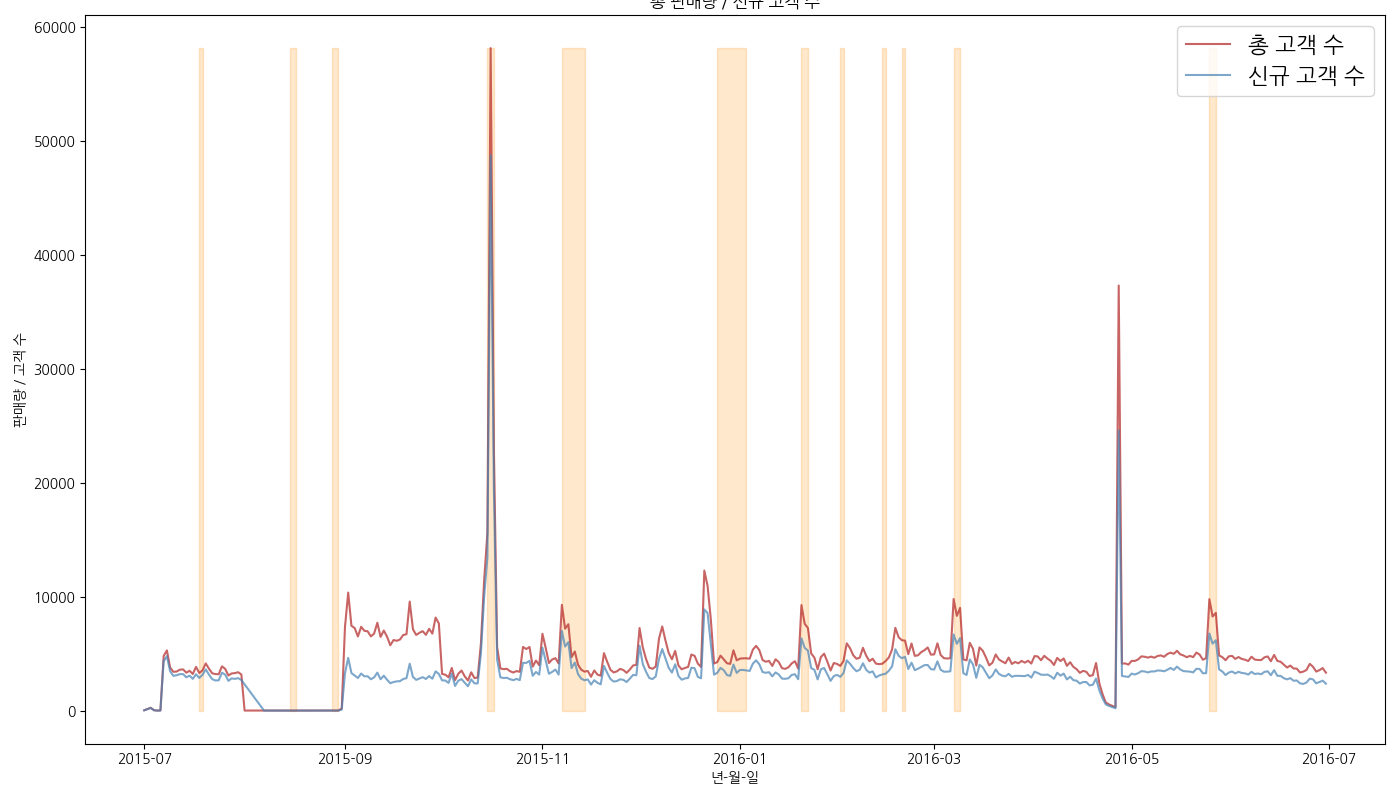

In [60]:
total_unit = ce_sort[(ce_sort['ymd']>'2015-06-30')&(ce_sort['ymd']<'2016-07-01')].groupby(['ymd'])['units'].sum().reset_index()
new_cust = ce_sort[(ce_sort['C']==0)&(ce_sort['ymd']>'2015-06-30')&(ce_sort['ymd']<'2016-07-01')].groupby(['ymd'])['cust_id'].nunique().reset_index()
    
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(111)

ax1.set_xlabel('년-월-일')
ax1.set_ylabel('판매량 / 고객 수', color='black')
ax1.plot(total_unit['ymd'], total_unit['units'], color='firebrick', alpha=0.7, label='총 고객 수')
ax1.tick_params(axis='y', labelcolor='black')

ax1.plot(new_cust['ymd'], new_cust['cust_id'], color='steelblue', alpha=0.7, label='신규 고객 수')

y_max = total_unit['units'].max()
    
for index, row in new_df.iterrows():
    start = mdates.date2num(row['start_date'])
    end = mdates.date2num(row['end_date'])
    width = end - start

    shp = patches.Rectangle((start, 0), width, y_max, alpha=0.2, color='darkorange')
    plt.gca().add_patch(shp)

ax1.legend(loc='upper right', prop={'size': 16})
fig.tight_layout()
plt.title(f'총 판매량 / 신규 고객 수')
plt.show()

In [61]:
unit_sum = ce_sort.groupby('ymd')['units'].sum().reset_index()
new_sum = ce_sort[ce_sort['C']==0].groupby('ymd')['cust_id'].nunique().reset_index()
df = pd.merge(unit_sum, new_sum, how='left', on='ymd')
df.head()

,ymd,units,cust_id
0,2015-05-19,1,1.0
1,2015-06-11,1,1.0
2,2015-06-24,1,1.0
3,2015-06-25,1,1.0
4,2015-06-26,3,3.0


In [62]:
promo_totalcust = ce_sort.groupby('promo_num')['cust_id'].nunique().reset_index()
promo_totalcust.columns = ['promo_num', 'total_count']
promo_totalcust

,promo_num,total_count
0,0.0,6364
1,1.0,3
2,2.0,8
3,3.0,86142
4,4.0,40411
5,5.0,40533
6,6.0,20885
7,7.0,7708
8,8.0,7893
9,9.0,11397


## 신규 유입

In [63]:
promo_newcust = ce_sort[(ce_sort['C']==0)].groupby('promo_num')['cust_id'].nunique().reset_index()
promo_newcust.columns = ['promo_num', 'new_count']
promo_newcust

,promo_num,new_count
0,0.0,6009
1,1.0,2
2,2.0,8
3,3.0,81570
4,4.0,35214
5,5.0,34766
6,6.0,17107
7,7.0,6258
8,8.0,6406
9,9.0,9314


In [64]:
promo_cust = pd.merge(promo_totalcust, promo_newcust, how='left', on='promo_num')
promo_cust['ratio'] = promo_cust['new_count']*100 / promo_cust['total_count']
promo_cust

,promo_num,total_count,new_count,ratio
0,0.0,6364,6009,94.421747
1,1.0,3,2,66.666667
2,2.0,8,8,100.000000
3,3.0,86142,81570,94.692485
4,4.0,40411,35214,87.139640
5,5.0,40533,34766,85.772087
6,6.0,20885,17107,81.910462
7,7.0,7708,6258,81.188376
8,8.0,7893,6406,81.160522
9,9.0,11397,9314,81.723261


In [65]:
promo_cateval = markm2[markm2['C']==0].groupby(['promo_num', 'product_analytic_category'])['product_analytic_category'].count().reset_index(name='count').sort_values(['promo_num', 'count'], ascending=[True, False]).reset_index(drop=True)
promo_cateval = promo_cateval[promo_cateval['promo_num']>=3]

In [66]:
monthly1 = {
    'promo_num': [0,1,2,3,4,5,6,7,8,9,10,11],
    'month_new': [78421,110,110,173621,103045,122726,110270,108958,108958,108958,112825,115502],
    'promo_period': [2,3,3,3,13,13,3,2,2,2,3,3]
}
monthly_df = pd.DataFrame(monthly1)
promo_cust = pd.merge(promo_cust, monthly_df, how='left', on='promo_num')

In [67]:
promo_cust['promo_new_day'] = round(promo_cust['new_count']/promo_cust['promo_period'])
promo_cust['total_new_day'] = round(promo_cust['month_new']/31)
promo_cust = promo_cust[promo_cust['promo_num']>2]

In [68]:
monthly_new = ce_sort[ce_sort['C']==0].groupby(['Year', 'Month'])['cust_id'].nunique().reset_index()
monthly_new = monthly_new.iloc[2:13,:]
monthly_new

,Year,Month,cust_id
2,2015,7,78421
3,2015,8,110
4,2015,9,90347
5,2015,10,173621
6,2015,11,103045
7,2015,12,122726
8,2016,1,110270
9,2016,2,109858
10,2016,3,112825
11,2016,4,95164


c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


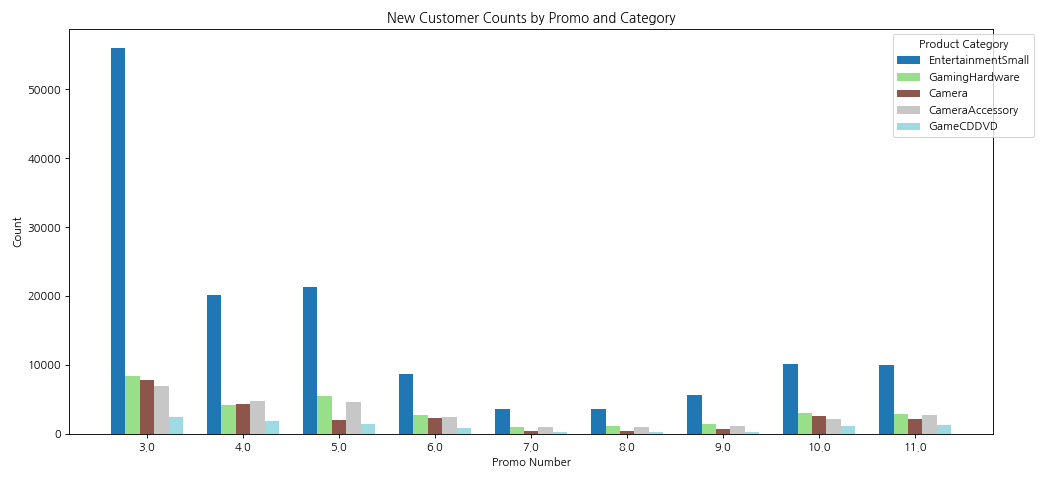

In [69]:
fig, ax = plt.subplots(figsize=(13, 6), dpi=80)


promo_nums = sorted(promo_cateval['promo_num'].unique())
width = 0.15
x = np.arange(len(promo_nums))


categories = promo_cateval['product_analytic_category'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))


for i, category in enumerate(categories):
    category_data = promo_cateval[promo_cateval['product_analytic_category'] == category]
    ax.bar(x + i * width - (width * (len(categories) - 1) / 2), category_data['count'], width, label=category, color=colors[i])


ax.set_xlabel('Promo Number')
ax.set_ylabel('Count')
ax.set_title('New Customer Counts by Promo and Category')
ax.set_xticks(x)
ax.set_xticklabels(promo_nums)
ax.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()


In [70]:
newcust_df = ce_sort[(ce_sort['C']==0)]

In [71]:
promo_dict = {}

for promo_num in newcust_df['promo_num'].unique():
    key = f'promo{promo_num}'
    promo_dict[key] = newcust_df[newcust_df['promo_num'] == promo_num]['cust_id'].unique()

promo_idlist = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in promo_dict.items()]))
promo_idlist = promo_idlist.drop(['promonan'],axis=1)
promo_idlist.columns = [3,4,7,5,11,0,6,10,8,9,2,1]
c_sort = [0,1,2,3,4,5,6,7,8,9,10,11]
promo_idlist = promo_idlist[c_sort]

In [72]:
results = []

for val in promo_idlist.columns:
    gmv_s = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[val]))]['gmv'].sum()
    unit = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[val]))]['units'].sum()
    cust = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[val]))]['cust_id'].nunique()
    
    results.append({'promo_num': val, 'gmv_sum': round(gmv_s), 'unit': unit, 'cust': cust})
    
promo_newcust_gmv = pd.DataFrame(results)
promo_newcust_gmv['gmv_per_unit'] = round(promo_newcust_gmv['gmv_sum']/promo_newcust_gmv['unit'])
promo_newcust_gmv = promo_newcust_gmv[promo_newcust_gmv['promo_num']>2]
promo_newcust_gmv['promo_month'] = ['2015년 10월', '2015년 11월', '2015년 12월', '2016년 1월', '2016년 2월(1)', '2016년 2월(2)', '2016년 2월(3)', '2016년 3월', '2016년 5월']

In [73]:
promo_cust['promo_month'] = ['2015년 10월', '2015년 11월', '2015년 12월', '2016년 1월', '2016년 2월(1)', '2016년 2월(2)', '2016년 2월(3)', '2016년 3월', '2016년 5월']
promo_cust

,promo_num,total_count,new_count,ratio,month_new,promo_period,promo_new_day,total_new_day,promo_month
3,3.0,86142,81570,94.692485,173621,3,27190.0,5601.0,2015년 10월
4,4.0,40411,35214,87.139640,103045,13,2709.0,3324.0,2015년 11월
5,5.0,40533,34766,85.772087,122726,13,2674.0,3959.0,2015년 12월
6,6.0,20885,17107,81.910462,110270,3,5702.0,3557.0,2016년 1월
7,7.0,7708,6258,81.188376,108958,2,3129.0,3515.0,2016년 2월(1)
8,8.0,7893,6406,81.160522,108958,2,3203.0,3515.0,2016년 2월(2)
9,9.0,11397,9314,81.723261,108958,2,4657.0,3515.0,2016년 2월(3)
10,10.0,23678,18900,79.820931,112825,3,6300.0,3640.0,2016년 3월
11,11.0,23851,18810,78.864618,115502,3,6270.0,3726.0,2016년 5월


In [74]:

between_promo = { 'promo_num': [3,4,5,6,7,8,9,10,11],
                 'bet_unit_mean':
    [round(ce_sort[(ce_sort['ymd']>'2015-08-30')&(ce_sort['ymd']<'2015-10-15')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2015-10-17')&(ce_sort['ymd']<'2015-11-07')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2015-11-14')&(ce_sort['ymd']<'2015-12-25')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-01-03')&(ce_sort['ymd']<'2016-01-20')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-01-22')&(ce_sort['ymd']<'2016-02-01')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-02-02')&(ce_sort['ymd']<'2016-02-14')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-02-15')&(ce_sort['ymd']<'2016-02-20')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-02-21')&(ce_sort['ymd']<'2016-03-07')].groupby('ymd')['cust_id'].nunique().mean()),
    round(ce_sort[(ce_sort['ymd']>'2016-03-09')&(ce_sort['ymd']<'2016-05-25')].groupby('ymd')['cust_id'].nunique().mean())],
                'promo_mean':
                    [round(ce_sort[ce_sort['promo_num']==3].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==4].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==5].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==6].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==7].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==8].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==9].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==10].groupby('ymd')['cust_id'].nunique().mean()),
                     round(ce_sort[ce_sort['promo_num']==11].groupby('ymd')['cust_id'].nunique().mean())]
}

between_promo_df = pd.DataFrame(between_promo)
between_promo_df

,promo_num,bet_unit_mean,promo_mean
0,3,3326,29202
1,4,4085,5188
2,5,4322,4195
3,6,4085,7108
4,7,4010,3880
5,8,4455,3958
6,9,5462,5740
7,10,4701,8053
8,11,4269,8084


c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


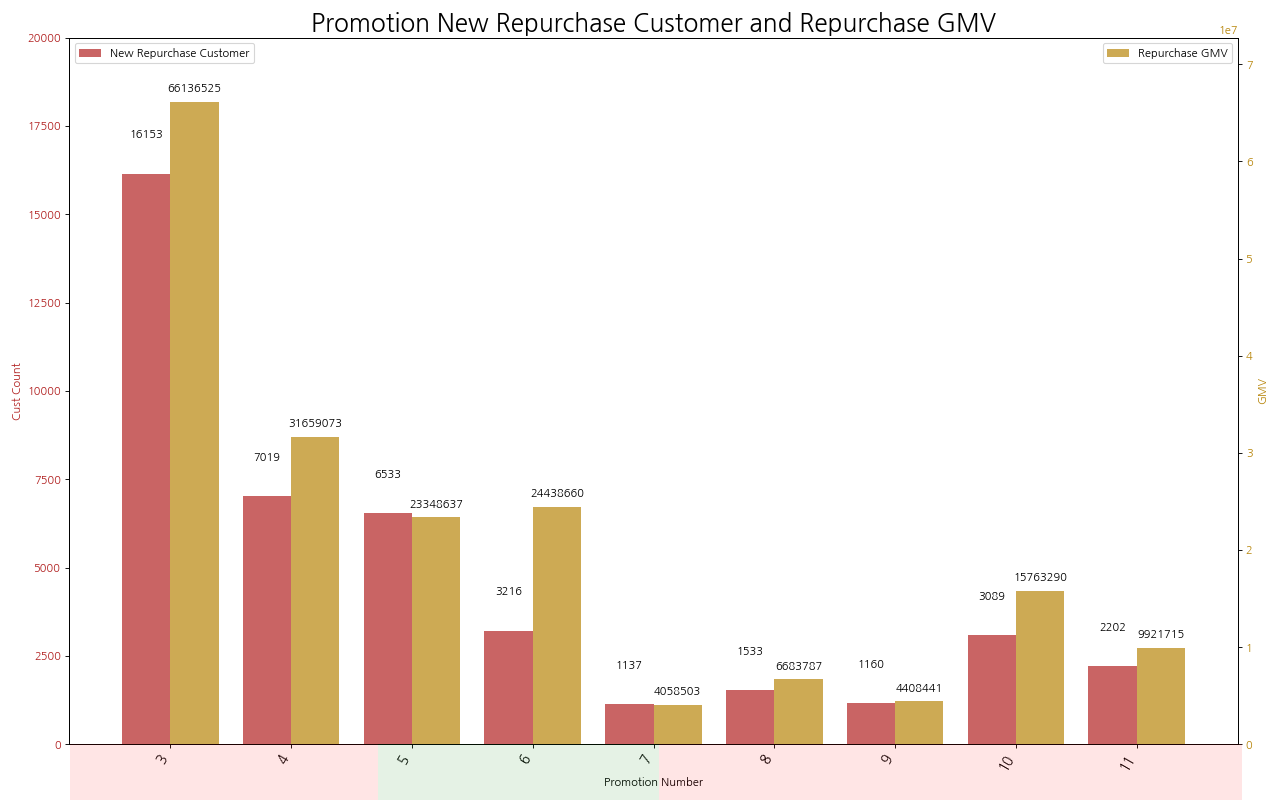

In [75]:
x = np.arange(len(promo_newcust_gmv['promo_num']))
fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='white', dpi=80)

width = 0.4 
offset = width / 2

ax1.bar(x - offset, promo_newcust_gmv['cust'], width=width, color='firebrick', alpha=0.7, label='New Repurchase Customer')


for i, new_count in enumerate(promo_newcust_gmv['cust']):
    ax1.text(x[i] - offset, new_count + 1000, round(new_count, 1), horizontalalignment='center')


ax2 = ax1.twinx()


ax2.bar(x + offset, promo_newcust_gmv['gmv_sum'], width=width, color='#b8860b', alpha=0.7, label='Repurchase GMV')


for i, gmv_sum in enumerate(promo_newcust_gmv['gmv_sum']):
    ax2.text(x[i] + offset, gmv_sum + 1000000, round(gmv_sum, 1), horizontalalignment='center')


ax1.set_title('Promotion New Repurchase Customer and Repurchase GMV', fontdict={'size':22})
ax1.set_xlabel('Promotion Number')
ax1.set_ylabel('Cust Count', color='firebrick')
ax1.set_xticks(x)
ax1.set_xticklabels(promo_newcust_gmv['promo_num'], rotation=60, horizontalalignment='right', fontsize=12)
ax1.set_ylim(0, 20000)
ax1.tick_params(axis='y', labelcolor='firebrick')

ax2.set_ylabel('GMV', color='#b8860b')
ax2.set_ylim(0, max(promo_newcust_gmv['gmv_sum']) * 1.1)
ax2.tick_params(axis='y', labelcolor='#b8860b')

p1 = patches.Rectangle((.295, -0.005), width=.22, height=.075, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.055, -0.005), width=.24, height=.075, alpha=.1, facecolor='red', transform=fig.transFigure)
p3 = patches.Rectangle((.515, -0.005), width=.455, height=.075, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
fig.add_artist(p3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


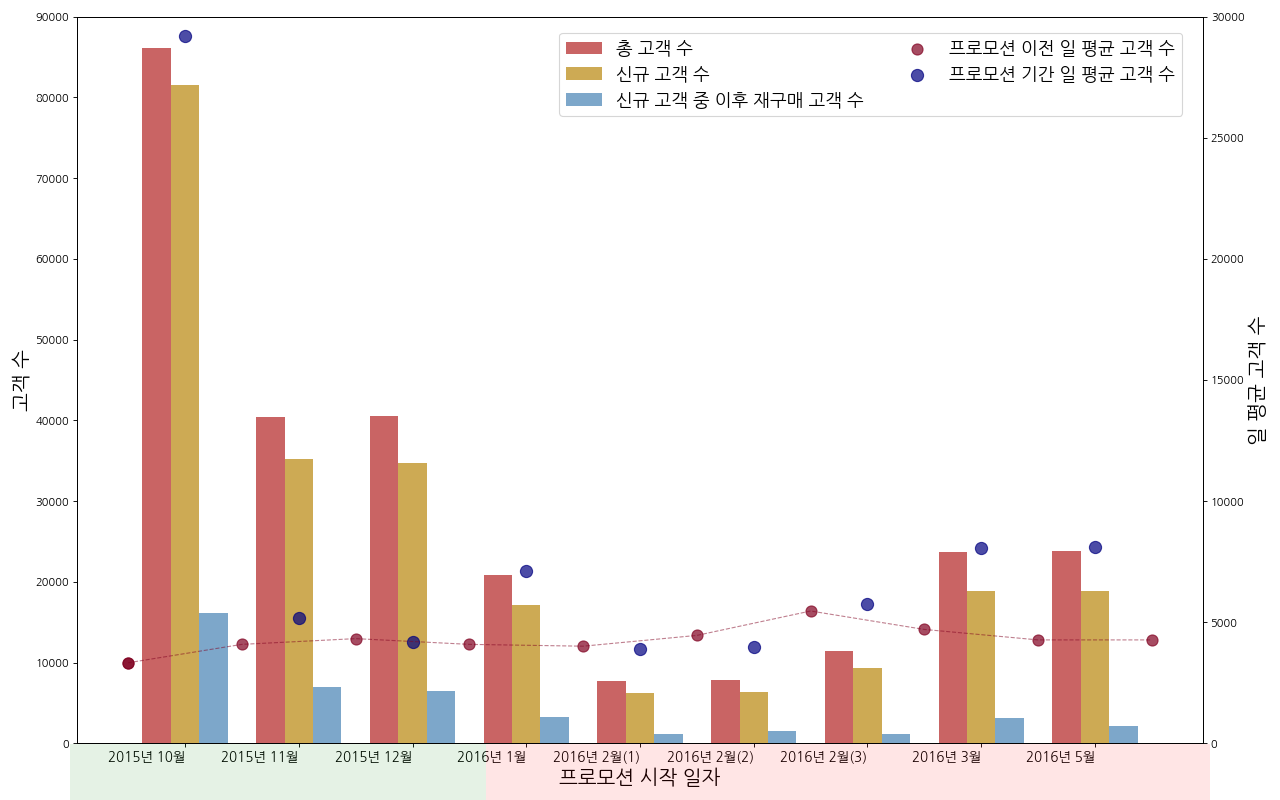

In [76]:
x = np.arange(len(promo_cust['promo_month']))

fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='white', dpi=80)

width = 0.25
offset = width / 2

extended_x = np.concatenate(([x[0]], x, [x[-1] + 1]))
extended_bet_unit_mean = np.concatenate(([between_promo_df['bet_unit_mean'].iloc[0]], 
                                          between_promo_df['bet_unit_mean'].values, 
                                          [between_promo_df['bet_unit_mean'].iloc[-1]]))

ax1.bar(x - width, promo_cust['total_count'], width=width, color='firebrick', alpha=0.7, label='총 고객 수')
ax1.bar(x, promo_cust['new_count'], width=width, color='#b8860b', alpha=0.7, label='신규 고객 수')
ax1.bar(x + width, promo_newcust_gmv['cust'], width=width, color='steelblue', alpha=0.7, label='신규 고객 중 이후 재구매 고객 수')
ax2 = ax1.twinx()
ax2.scatter(extended_x - 2*width, extended_bet_unit_mean, s= 100, color='#800020', alpha=0.7, label='프로모션 이전 일 평균 고객 수')
ax2.plot(extended_x - 2*width, extended_bet_unit_mean,  
         color='#800020', alpha=0.5, linestyle='--', linewidth=1)
ax2.scatter(x, between_promo_df['promo_mean'], s= 120, marker='o', color='#000080', alpha=0.7, label='프로모션 기간 일 평균 고객 수')


# for i, total_count in enumerate(promo_cust['total_count']):
#     ax1.text(x[i] - width, total_count + 500, round(total_count, 1), horizontalalignment='center')

# for i, new_count in enumerate(promo_cust['new_count']):
#     ax1.text(x[i] +0.06, new_count + 500, round(new_count, 1), horizontalalignment='center')
    
# for i, cust in enumerate(promo_newcust_gmv['cust']):
#     ax1.text(x[i] +0.06 + width, cust + 1000, round(cust, 1), horizontalalignment='center')


# ax1.set_title('프로모션별 총 고객 / 신규 고객 / 이후 재구매 고객', fontdict={'size':22})
ax1.set_xlabel('프로모션 시작 일자', fontdict={'size':18})
ax1.set_ylabel('고객 수', color='black', fontdict={'size':18})
ax1.set_xticks(x)
ax1.set_xticklabels(promo_cust['promo_month'], rotation=0, horizontalalignment='right', fontsize=12)
ax1.set_ylim(0, 90000)
ax1.tick_params(axis='y', labelcolor='black')

ax2.set_ylabel('일 평균 고객 수', color='black', fontdict={'size':18})
ax2.set_ylim(0, 30000)

p1 = patches.Rectangle((.055, -0.02), width=.325, height=.09, alpha=.1, facecolor='green', transform=fig.transFigure)
p2 = patches.Rectangle((.38, -0.02), width=.565, height=.09, alpha=.1, facecolor='red', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)

# ax1.legend(loc='upper right', prop={'size': 15})
# ax2.legend(loc='best', prop={'size': 15})

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 모든 핸들 및 레이블을 하나로 결합
handles = handles1 + handles2
labels = labels1 + labels2

# 전체 플롯에 단일 레전드 추가
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.43, 0.97), ncol=2, prop={'size': 16})

plt.tight_layout()
plt.show()


In [77]:
pro0 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[0]))]['product_analytic_category'].value_counts().reset_index()
pro0.columns = ['Category', 0]
pro1 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[1]))]['product_analytic_category'].value_counts().reset_index()
pro1.columns = ['Category', 1]
pro2 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[2]))]['product_analytic_category'].value_counts().reset_index()
pro2.columns = ['Category', 2]
pro3 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[3]))]['product_analytic_category'].value_counts().reset_index()
pro3.columns = ['Category', 3]
pro4 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[4]))]['product_analytic_category'].value_counts().reset_index()
pro4.columns = ['Category', 4]
pro5 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[5]))]['product_analytic_category'].value_counts().reset_index()
pro5.columns = ['Category', 5]
pro6 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[6]))]['product_analytic_category'].value_counts().reset_index()
pro6.columns = ['Category', 6]
pro7 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[7]))]['product_analytic_category'].value_counts().reset_index()
pro7.columns = ['Category', 7]
pro8 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[8]))]['product_analytic_category'].value_counts().reset_index()
pro8.columns = ['Category', 8]
pro9 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[9]))]['product_analytic_category'].value_counts().reset_index()
pro9.columns = ['Category', 9]
pro10 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[10]))]['product_analytic_category'].value_counts().reset_index()
pro10.columns = ['Category', 10]
pro11 = ce_sort[(ce_sort['C'].isna())&(ce_sort['cust_id'].isin(promo_idlist[11]))]['product_analytic_category'].value_counts().reset_index()
pro11.columns = ['Category', 11]
react_cate = pd.merge(pro0, pro1, how='left', on='Category')
react_cate = pd.merge(react_cate, pro2, how='left', on='Category')
react_cate = pd.merge(react_cate, pro3, how='left', on='Category')
react_cate = pd.merge(react_cate, pro4, how='left', on='Category')
react_cate = pd.merge(react_cate, pro5, how='left', on='Category')
react_cate = pd.merge(react_cate, pro6, how='left', on='Category')
react_cate = pd.merge(react_cate, pro7, how='left', on='Category')
react_cate = pd.merge(react_cate, pro8, how='left', on='Category')
react_cate = pd.merge(react_cate, pro9, how='left', on='Category')
react_cate = pd.merge(react_cate, pro10, how='left', on='Category')
react_cate = pd.merge(react_cate, pro11, how='left', on='Category')

react_cate

,Category,0,1,2,3,4,5,6,7,8,9,10,11
0,EntertainmentSmall,1083,3.0,3.0,13802,5245,5036,1970,877,1237,802,1973,1191
1,GameCDDVD,700,NaN,NaN,2842,1655,1112,774,125,196,186,688,389
2,GamingHardware,446,NaN,8.0,3308,1471,1380,771,241,307,280,618,400
3,CameraAccessory,430,1.0,6.0,4701,2161,1762,957,339,428,326,935,643
4,Camera,81,NaN,1.0,1552,658,391,691,89,156,97,349,227


# 프로모션 별 재활성

In [78]:
ce_sort[ce_sort['re_pur']>0]['re_pur'].describe()

count    811534.000000
mean         89.354977
std          78.089072
min           1.000000
25%          22.000000
50%          70.000000
75%         140.000000
max         370.000000
Name: re_pur, dtype: float64

In [79]:
markm2[(markm2['C'].isna())&(markm2['re_pur']>0)]['re_pur'].describe()

count    40421.000000
mean        43.293288
std         55.026787
min          1.000000
25%          5.000000
50%         20.000000
75%         65.000000
max        328.000000
Name: re_pur, dtype: float64

In [80]:
promo_retension = markm2[(markm2['C'].isna())&(markm2['re_pur']>30)].groupby('promo_num')['cust_id'].nunique().reset_index()
promo_retension.columns = ['promo_num', 'reten_count']

In [81]:
ce_last = ce_sort.sort_values(['cust_id', 'order_date']).drop_duplicates(subset='cust_id', keep='last')

In [82]:
act_cust = ce_sort[(ce_sort['ymd']>='2015-09-15')&(ce_sort['ymd']<='2015-10-14')]['cust_id'].unique()
promo3 = ce_sort[(ce_sort['ymd']<'2015-09-15')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2015-10-07')&(ce_sort['ymd']<='2015-11-06')]['cust_id'].unique()
promo4 = ce_sort[(ce_sort['ymd']<'2015-10-07')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2015-11-25')&(ce_sort['ymd']<='2015-12-24')]['cust_id'].unique()
promo5 = ce_sort[(ce_sort['ymd']<'2015-11-25')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2015-12-20')&(ce_sort['ymd']<='2016-01-19')]['cust_id'].unique()
promo6 = ce_sort[(ce_sort['ymd']<'2015-12-20')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2016-01-01')&(ce_sort['ymd']<='2016-01-31')]['cust_id'].unique()
promo7 = ce_sort[(ce_sort['ymd']<'2016-01-01')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2016-01-14')&(ce_sort['ymd']<='2016-02-13')]['cust_id'].unique()
promo8 = ce_sort[(ce_sort['ymd']<'2016-01-14')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2016-1-20')&(ce_sort['ymd']<='2016-02-19')]['cust_id'].unique()
promo9 = ce_sort[(ce_sort['ymd']<'2016-01-20')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2016-02-07')&(ce_sort['ymd']<='2016-03-06')]['cust_id'].unique()
promo10 = ce_sort[(ce_sort['ymd']<'2016-02-07')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
act_cust = ce_sort[(ce_sort['ymd']>='2016-04-25')&(ce_sort['ymd']<='2016-05-24')]['cust_id'].unique()
promo11 = ce_sort[(ce_sort['ymd']<'2016-04-25')&(ce_sort['next_pur']>30)&(~ce_sort['cust_id'].isin(act_cust))]['cust_id'].nunique()
p3 = ce_sort[ce_sort['ymd']<='2015-10-17']['cust_id'].nunique()
p4 = ce_sort[ce_sort['ymd']<='2015-11-15']['cust_id'].nunique()
p5 = ce_sort[ce_sort['ymd']<='2016-01-03']['cust_id'].nunique()
p6 = ce_sort[ce_sort['ymd']<='2016-01-22']['cust_id'].nunique()
p7 = ce_sort[ce_sort['ymd']<='2016-02-02']['cust_id'].nunique()
p8 = ce_sort[ce_sort['ymd']<='2016-02-15']['cust_id'].nunique()
p9 = ce_sort[ce_sort['ymd']<='2016-02-22']['cust_id'].nunique()
p10 = ce_sort[ce_sort['ymd']<='2016-03-09']['cust_id'].nunique()
p11 = ce_sort[ce_sort['ymd']<='2016-05-27']['cust_id'].nunique()
r3 = ce_sort[ce_sort['promo_num']==3]['cust_id'].count()
r4 = ce_sort[ce_sort['promo_num']==4]['cust_id'].count()
r5 = ce_sort[ce_sort['promo_num']==5]['cust_id'].count()
r6 = ce_sort[ce_sort['promo_num']==6]['cust_id'].count()
r7 = ce_sort[ce_sort['promo_num']==7]['cust_id'].count()
r8 = ce_sort[ce_sort['promo_num']==8]['cust_id'].count()
r9 = ce_sort[ce_sort['promo_num']==9]['cust_id'].count()
r10 = ce_sort[ce_sort['promo_num']==10]['cust_id'].count()
r11 = ce_sort[ce_sort['promo_num']==11]['cust_id'].count()
c3 = ce_sort[(ce_sort['promo_num']==3)&(ce_sort['C'].isna())]['cust_id'].count()
c4 = ce_sort[(ce_sort['promo_num']==4)&(ce_sort['C'].isna())]['cust_id'].count()
c5 = ce_sort[(ce_sort['promo_num']==5)&(ce_sort['C'].isna())]['cust_id'].count()
c6 = ce_sort[(ce_sort['promo_num']==6)&(ce_sort['C'].isna())]['cust_id'].count()
c7 = ce_sort[(ce_sort['promo_num']==7)&(ce_sort['C'].isna())]['cust_id'].count()
c8 = ce_sort[(ce_sort['promo_num']==8)&(ce_sort['C'].isna())]['cust_id'].count()
c9 = ce_sort[(ce_sort['promo_num']==9)&(ce_sort['C'].isna())]['cust_id'].count()
c10 = ce_sort[(ce_sort['promo_num']==10)&(ce_sort['C'].isna())]['cust_id'].count()
c11 = ce_sort[(ce_sort['promo_num']==11)&(ce_sort['C'].isna())]['cust_id'].count()





total_user = {
    'promo_num': [3,4,5,6,7,8,9,10,11],
    'total_user': [promo3, promo4,promo5,promo6,promo7,promo8,promo9,promo10,promo11],
    'ac+de_user': [p3,p4,p5,p6,p7,p8,p9,p10,p11],
    'promo_user': [r3,r4,r5,r6,r7,r8,r9,r10,r11],
    're_user': [c3,c4,c5,c6,c7,c8,c9,c10,c11]
}

total = pd.DataFrame(total_user)
total

,promo_num,total_user,ac+de_user,promo_user,re_user
0,3,107850,296161,94746,13176
1,4,151620,403735,43991,8777
2,5,311634,578924,44260,9494
3,6,358005,649192,23244,6137
4,7,384314,684805,8144,1886
5,8,405280,730999,8333,1927
6,9,411878,761531,12130,2816
7,10,439045,829087,26162,7262
8,11,501483,1098395,26111,7301


In [83]:
total_retension = pd.merge(promo_retension, total, how='left', on='promo_num')
total_retension['pre_c'] = total_retension['reten_count'].shift(1).fillna(0)
total_retension['cum'] = total_retension['pre_c'].cumsum()
total_retension = total_retension.drop(['pre_c', 'cum'], axis=1)
total_retension['ratio1'] = total_retension['reten_count']*100/total_retension['total_user']
total_retension['total_ratio'] = total_retension['total_user']*100/total_retension['ac+de_user']
total_retension['active_user'] = total_retension['ac+de_user'] - total_retension['total_user']
total_retension['active_ratio'] = total_retension['total_user']*100 / total_retension['active_user']
total_retension['promo_ratio'] = total_retension['total_user']*100/total_retension['promo_user']
total_retension['promo_month'] = ['2015년 10월', '2015년 11월', '2015년 12월', '2016년 1월', '2016년 2월(1)', '2016년 2월(2)', '2016년 2월(3)', '2016년 3월', '2016년 5월']
total_retension

,promo_num,reten_count,total_user,ac+de_user,promo_user,re_user,ratio1,total_ratio,active_user,active_ratio,promo_ratio,promo_month
0,3.0,1750,107850,296161,94746,13176,1.622624,36.416003,188311,57.272278,113.830663,2015년 10월
1,4.0,1379,151620,403735,43991,8777,0.909511,37.554336,252115,60.139222,344.661408,2015년 11월
2,5.0,2841,311634,578924,44260,9494,0.911646,53.829864,267290,116.590220,704.098509,2015년 12월
3,6.0,1858,358005,649192,23244,6137,0.518987,55.146243,291187,122.946766,1540.203924,2016년 1월
4,7.0,689,384314,684805,8144,1886,0.179280,56.120209,300491,127.895345,4718.983301,2016년 2월(1)
5,8.0,700,405280,730999,8333,1927,0.172720,55.441936,325719,124.426269,4863.554542,2016년 2월(2)
6,9.0,1059,411878,761531,12130,2816,0.257115,54.085520,349653,117.796215,3395.531739,2016년 2월(3)
7,10.0,2558,439045,829087,26162,7262,0.582628,52.955239,390042,112.563519,1678.178274,2016년 3월
8,11.0,3048,501483,1098395,26111,7301,0.607797,45.655980,596912,84.012886,1920.581364,2016년 5월


c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


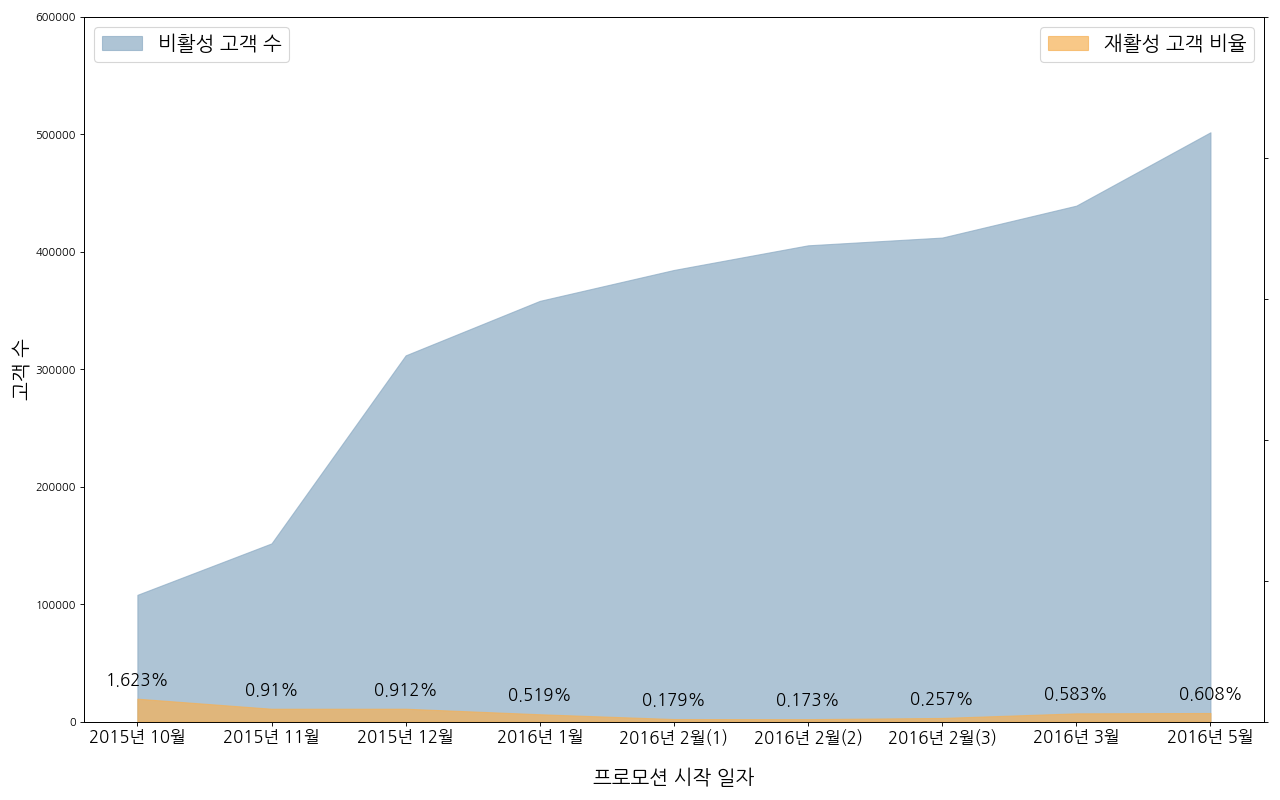

In [84]:
x = np.arange(len(total_retension['promo_month']))
fig, ax1 = plt.subplots(figsize=(16, 10), facecolor='white', dpi=80)

# 첫 번째 영역형 차트 (비활성 고객 수)
ax1.fill_between(x, total_retension['total_user'], color='#8cabc4', alpha=0.7, label='비활성 고객 수')

# 두 번째 축 생성 및 영역형 차트 (재활성 고객 수)
ax2 = ax1.twinx()
ax2.fill_between(x, total_retension['ratio1'], color='#f6b155', alpha=0.7, label='재활성 고객 비율')

# 텍스트 추가 (재활성 고객 수)
# for i, (reten_count, ratio) in enumerate(zip(total_retension['reten_count'], total_retension['ratio'])):
#     ax2.text(x[i], reten_count + 1000, f"{round(ratio, 3)}%", horizontalalignment='center', fontsize=15)
    
for i, ratio in enumerate(total_retension['ratio1']):
    ax2.text(x[i], ratio +1 , f"{round(ratio, 3)}%", horizontalalignment='center', fontsize=15)

# 제목과 축 레이블 설정
# ax1.set_title('프로모션별 비활성 고객 / 재활성 고객', fontdict={'size':22})
ax1.set_xlabel('프로모션 시작 일자', fontdict={'size':18}, labelpad=20)
ax1.set_ylabel('고객 수', color='black', fontdict={'size':18})
ax1.set_xticks(x)
ax1.set_xticklabels(total_retension['promo_month'], rotation=0, horizontalalignment='center', fontsize=15)

# y축 범위 설정
ax1.set_ylim(0, 600000)
ax2.set_ylim(0, 50)

# y축 눈금 설정
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', which='both', labelleft=False, labelright=False)

# 범례 설정
ax1.legend(loc='upper left', prop={'size': 18})
ax2.legend(loc='upper right', prop={'size': 18})

plt.tight_layout()
plt.show()

In [85]:
retension_cust = pd.merge(promo_totalcust, promo_retension, how='left', on='promo_num')
retension_cust['reten_ratio'] = retension_cust['reten_count']*100/retension_cust['total_count']
retension_cust

,promo_num,total_count,reten_count,reten_ratio
0,0.0,6364,NaN,NaN
1,1.0,3,NaN,NaN
2,2.0,8,NaN,NaN
3,3.0,86142,1750.0,2.031529
4,4.0,40411,1379.0,3.412437
5,5.0,40533,2841.0,7.009104
6,6.0,20885,1858.0,8.896337
7,7.0,7708,689.0,8.938765
8,8.0,7893,700.0,8.868618
9,9.0,11397,1059.0,9.291919


In [86]:
react_cate = react_cate.T
react_cate.columns = react_cate.iloc[0] 
react_cate = react_cate[1:].reset_index(drop=True)
react_cate  

Category,EntertainmentSmall,GameCDDVD,GamingHardware,CameraAccessory,Camera
0,1083,700,446,430,81
1,3.0,NaN,NaN,1.0,NaN
2,3.0,NaN,8.0,6.0,1.0
3,13802,2842,3308,4701,1552
4,5245,1655,1471,2161,658
5,5036,1112,1380,1762,391
6,1970,774,771,957,691
7,877,125,241,339,89
8,1237,196,307,428,156
9,802,186,280,326,97


# 카테고리별 고객 탐색

In [87]:
promo_newcuca = ce_sort[(ce_sort['C']==0)].groupby(['promo_num', 'product_analytic_category'])['cust_id'].nunique().reset_index()
promo_newcuca.columns = ['promo_num', 'Category', 'new_count']
promo_newcuca

,promo_num,Category,new_count
0,0.0,Camera,268
1,0.0,CameraAccessory,797
2,0.0,EntertainmentSmall,3688
3,0.0,GameCDDVD,471
4,0.0,GamingHardware,785
5,1.0,CameraAccessory,1
6,1.0,EntertainmentSmall,1
7,2.0,Camera,1
8,2.0,CameraAccessory,2
9,2.0,EntertainmentSmall,2


In [88]:
promo_totalcuca = ce_sort.groupby(['promo_num', 'product_analytic_category'])['cust_id'].nunique().reset_index()
promo_totalcuca.columns = ['promo_num', 'Category','total_count']
promo_totalcuca

,promo_num,Category,total_count
0,0.0,Camera,283
1,0.0,CameraAccessory,862
2,0.0,EntertainmentSmall,3894
3,0.0,GameCDDVD,520
4,0.0,GamingHardware,838
5,1.0,CameraAccessory,1
6,1.0,EntertainmentSmall,2
7,2.0,Camera,1
8,2.0,CameraAccessory,2
9,2.0,EntertainmentSmall,2


In [89]:
promo_cuca = pd.merge(promo_totalcuca, promo_newcuca, how='left', on=['promo_num', 'Category'])
promo_cuca['ratio'] = promo_cuca['new_count']*100 / promo_cuca['total_count']
promo_cuca

,promo_num,Category,total_count,new_count,ratio
0,0.0,Camera,283,268,94.699647
1,0.0,CameraAccessory,862,797,92.459397
2,0.0,EntertainmentSmall,3894,3688,94.709810
3,0.0,GameCDDVD,520,471,90.576923
4,0.0,GamingHardware,838,785,93.675418
5,1.0,CameraAccessory,1,1,100.000000
6,1.0,EntertainmentSmall,2,1,50.000000
7,2.0,Camera,1,1,100.000000
8,2.0,CameraAccessory,2,2,100.000000
9,2.0,EntertainmentSmall,2,2,100.000000


In [90]:
seq_fing2 = seq_fing[(seq_fing[0]=='PhysicalGame')|(seq_fing[0]=='GamePad')|(seq_fing[0]=='GamingConsole')].reset_index(drop=True)

In [91]:
results = []

for num in markm2['promo_num'].unique():
    for val in seq_fing2[0].unique():
        first_count = markm2[(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val)]['units'].sum()
        results.append({'promo_num': num, 'category': val, 'count': first_count})
    
promo_first_count = pd.DataFrame(results)

results2 = []
for num in markm2['promo_num'].unique():
    period = ce_sort[ce_sort['promo_num']==num]['ymd'].unique()
    for val in seq_fing2[0].unique():
        for val2 in seq_fing2[seq_fing2[0]==val][1].unique():
            in_promo_count = markm2[(markm2['pre_prd']==val)&(markm2['C'].isna())&(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val2)]['units'].sum()
            out_promo_count = nonmm2[(nonmm2['pre_prd']==val)&(nonmm2['C'].isna())&(nonmm2['pre_ymd'].isin(period))&(nonmm2['product_analytic_vertical']==val2)]['units'].sum()
            results2.append({'promo_num': num, 'category': val, 'in_promo': in_promo_count, 'out_promo': out_promo_count})
promo_second_count = pd.DataFrame(results2)

in_promo_second = promo_second_count.groupby(['promo_num', 'category'])['in_promo'].sum().reset_index()
out_promo_second = promo_second_count.groupby(['promo_num', 'category'])['out_promo'].sum().reset_index()
promo_second_count2 = pd.merge(in_promo_second, out_promo_second, how='left', on=['promo_num', 'category'])

game_list_count = pd.merge(promo_first_count, promo_second_count2, how='left', on=['promo_num', 'category'])
game_list_count = game_list_count.sort_values(['promo_num', 'category']).reset_index(drop=True)

In [92]:
game_list_count

,promo_num,category,count,in_promo,out_promo
0,0.0,GamePad,437,30,37
1,0.0,GamingConsole,15,4,2
2,0.0,PhysicalGame,577,83,146
3,1.0,GamePad,0,0,0
4,1.0,GamingConsole,0,0,0
5,1.0,PhysicalGame,0,0,0
6,2.0,GamePad,4,2,1
7,2.0,GamingConsole,0,0,0
8,2.0,PhysicalGame,0,0,0
9,3.0,GamePad,1518,164,144


In [93]:
grouped_game = game_list_count.groupby('category')[['count', 'in_promo', 'out_promo']].sum().reset_index()

In [94]:
counts = []
for _, row in seq_fing2.iterrows():
    count = ce_sort[(ce_sort['product_analytic_vertical'] == row[1]) & 
                (ce_sort['pre_prd'] == row[0])&
                   (ce_sort['C'].isna())]['re_pur'].mean()
    counts.append(round(count))

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

renc1 = seq_fing2.drop(['count'],axis=1).reset_index()
renc11 = pd.merge(renc1, counts_df, how='left', on='index')
renc11 = renc11.drop(['index'],axis=1)
renc11

,0,1,mean
0,PhysicalGame,PhysicalGame,29
1,GamePad,GamePad,15
2,GamingConsole,PhysicalGame,21
3,GamePad,PhysicalGame,43
4,PhysicalGame,GamePad,42
5,PhysicalGame,GamingConsole,20
6,GamingConsole,GamingConsole,7
7,PhysicalGame,GamingAccessoryKit,38
8,GamingConsole,GamePad,17
9,GamePad,GamingConsole,20


In [95]:
repur_game =  round(renc11.groupby(0)['mean'].mean().reset_index())

In [96]:
counts = []
for _, row in seq_fing2.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_fing2.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_fing2.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong121 = pd.merge(nong11, rats_df, how='left', on='index')
nong121 = nong121.drop(['index'],axis=1)
nong121['3%'] = round(nong121['ratio']*nong121['%']*3)
nong121['5%'] = round(nong121['ratio']*nong121['%']*5)
nong121['10%'] = round(nong121['ratio']*nong121['%']*10)
nong121 = nong121.drop(['sum', 'units', 'ratio', '%'], axis=1)
nong121.columns = ['First', 'Second', '3%', '5%', '10%']
nong121

,First,Second,3%,5%,10%
0,PhysicalGame,PhysicalGame,5043972.0,8406620.0,16813241.0
1,GamePad,GamePad,1566820.0,2611367.0,5222733.0
2,GamingConsole,PhysicalGame,504695.0,841158.0,1682315.0
3,GamePad,PhysicalGame,3243296.0,5405494.0,10810988.0
4,PhysicalGame,GamePad,5962116.0,9936860.0,19873719.0
5,PhysicalGame,GamingConsole,75693496.0,126155826.0,252311653.0
6,GamingConsole,GamingConsole,4676424.0,7794041.0,15588081.0
7,PhysicalGame,GamingAccessoryKit,1777581.0,2962635.0,5925271.0
8,GamingConsole,GamePad,605581.0,1009302.0,2018605.0
9,GamePad,GamingConsole,39940653.0,66567755.0,133135510.0


In [97]:
seq_finc2 = seq_finc[(seq_finc[0]=='DSLR')|(seq_finc[0]=='Lens')|(seq_finc[0]=='CameraBattery')].reset_index(drop=True)

In [98]:
results = []

for num in markm2['promo_num'].unique():
    for val in seq_finc2[0].unique():
        first_count = markm2[(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val)]['units'].sum()
        results.append({'promo_num': num, 'category': val, 'count': first_count})
    
promo_first_count = pd.DataFrame(results)

results2 = []
for num in markm2['promo_num'].unique():
    period = ce_sort[ce_sort['promo_num']==num]['ymd'].unique()
    for val in seq_finc2[0].unique():
        for val2 in seq_finc2[seq_finc2[0]==val][1].unique():
            in_promo_count = markm2[(markm2['pre_prd']==val)&(markm2['C'].isna())&(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val2)]['units'].sum()
            out_promo_count = nonmm2[(nonmm2['pre_prd']==val)&(nonmm2['C'].isna())&(nonmm2['pre_ymd'].isin(period))&(nonmm2['product_analytic_vertical']==val2)]['units'].sum()
            results2.append({'promo_num': num, 'category': val, 'in_promo': in_promo_count, 'out_promo': out_promo_count})
promo_second_count = pd.DataFrame(results2)

in_promo_second = promo_second_count.groupby(['promo_num', 'category'])['in_promo'].sum().reset_index()
out_promo_second = promo_second_count.groupby(['promo_num', 'category'])['out_promo'].sum().reset_index()
promo_second_count2 = pd.merge(in_promo_second, out_promo_second, how='left', on=['promo_num', 'category'])

cam_list_count = pd.merge(promo_first_count, promo_second_count2, how='left', on=['promo_num', 'category'])
cam_list_count = cam_list_count.sort_values(['promo_num', 'category']).reset_index(drop=True)

In [99]:
cam_list_count

,promo_num,category,count,in_promo,out_promo
0,0.0,CameraBattery,297,62,15
1,0.0,DSLR,64,4,3
2,0.0,Lens,163,28,12
3,1.0,CameraBattery,0,0,0
4,1.0,DSLR,0,0,0
5,1.0,Lens,0,0,0
6,2.0,CameraBattery,0,0,0
7,2.0,DSLR,2,1,0
8,2.0,Lens,3,1,1
9,3.0,CameraBattery,1111,131,63


In [100]:
grouped_cam = cam_list_count.groupby('category')[['count', 'in_promo', 'out_promo']].sum().reset_index()

In [101]:
counts = []
for _, row in seq_finc2.iterrows():
    count = ce_sort[(ce_sort['product_analytic_vertical'] == row[1]) & 
                (ce_sort['pre_prd'] == row[0])&
                   (ce_sort['C'].isna())]['re_pur'].mean()
    counts.append(round(count))

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

renc1 = seq_finc2.drop(['count'],axis=1).reset_index()
renc11 = pd.merge(renc1, counts_df, how='left', on='index')
renc11 = renc11.drop(['index'],axis=1)
renc11

,0,1,mean
0,DSLR,DSLR,11
1,DSLR,Lens,35
2,Lens,Lens,11
3,CameraBattery,CameraBattery,10
4,Lens,Filter,14
5,CameraBattery,CameraBatteryCharger,11
6,Lens,DSLR,16
7,DSLR,CameraTripod,28
8,DSLR,Filter,29
9,Lens,CameraTripod,32


In [102]:
repur_cam =  round(renc11.groupby(0)['mean'].mean().reset_index())

In [103]:
counts = []
for _, row in seq_finc2.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_finc2.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_finc2.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong122 = pd.merge(nong11, rats_df, how='left', on='index')
nong122 = nong122.drop(['index'],axis=1)
nong122['3%'] = round(nong122['ratio']*nong122['%']*3)
nong122['5%'] = round(nong122['ratio']*nong122['%']*5)
nong122['10%'] = round(nong122['ratio']*nong122['%']*10)
nong122 = nong122.drop(['sum', 'units', 'ratio', '%'], axis=1)
nong122.columns = ['First', 'Second', '3%', '5%', '10%']

nong122

,First,Second,3%,5%,10%
0,DSLR,DSLR,30874663.0,51457771.0,102915543.0
1,DSLR,Lens,8629094.0,14381823.0,28763646.0
2,Lens,Lens,3115664.0,5192773.0,10385546.0
3,CameraBattery,CameraBattery,636850.0,1061416.0,2122833.0
4,Lens,Filter,425646.0,709410.0,1418819.0
5,CameraBattery,CameraBatteryCharger,680721.0,1134535.0,2269070.0
6,Lens,DSLR,25696388.0,42827313.0,85654627.0
7,DSLR,CameraTripod,1178594.0,1964323.0,3928646.0
8,DSLR,Filter,509900.0,849833.0,1699667.0
9,Lens,CameraTripod,1096451.0,1827418.0,3654837.0


In [104]:
seq_fine2 = seq_fine[(seq_fine[0]=='LaptopSpeaker')|(seq_fine[0]=='MobileSpeaker')|(seq_fine[0]=='HomeAudioSpeaker')].reset_index(drop=True)

In [105]:
results = []

for num in markm2['promo_num'].unique():
    for val in seq_fine2[0].unique():
        first_count = markm2[(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val)]['units'].sum()
        results.append({'promo_num': num, 'category': val, 'count': first_count})
    
promo_first_count = pd.DataFrame(results)

results2 = []
for num in markm2['promo_num'].unique():
    period = ce_sort[ce_sort['promo_num']==num]['ymd'].unique()
    for val in seq_fine2[0].unique():
        for val2 in seq_fine2[seq_fine2[0]==val][1].unique():
            in_promo_count = markm2[(markm2['pre_prd']==val)&(markm2['C'].isna())&(markm2['promo_num']==num)&(markm2['product_analytic_vertical']==val2)]['units'].sum()
            out_promo_count = nonmm2[(nonmm2['pre_prd']==val)&(nonmm2['C'].isna())&(nonmm2['pre_ymd'].isin(period))&(nonmm2['product_analytic_vertical']==val2)]['units'].sum()
            results2.append({'promo_num': num, 'category': val, 'in_promo': in_promo_count, 'out_promo': out_promo_count})
promo_second_count = pd.DataFrame(results2)

in_promo_second = promo_second_count.groupby(['promo_num', 'category'])['in_promo'].sum().reset_index()
out_promo_second = promo_second_count.groupby(['promo_num', 'category'])['out_promo'].sum().reset_index()
promo_second_count2 = pd.merge(in_promo_second, out_promo_second, how='left', on=['promo_num', 'category'])

ent_list_count = pd.merge(promo_first_count, promo_second_count2, how='left', on=['promo_num', 'category'])
ent_list_count = ent_list_count.sort_values(['promo_num', 'category']).reset_index(drop=True)

In [106]:
ent_list_count

,promo_num,category,count,in_promo,out_promo
0,0.0,HomeAudioSpeaker,471,34,49
1,0.0,LaptopSpeaker,1418,89,137
2,0.0,MobileSpeaker,757,61,87
3,1.0,HomeAudioSpeaker,0,0,0
4,1.0,LaptopSpeaker,1,1,0
5,1.0,MobileSpeaker,2,1,1
6,2.0,HomeAudioSpeaker,0,0,0
7,2.0,LaptopSpeaker,0,0,0
8,2.0,MobileSpeaker,2,1,0
9,3.0,HomeAudioSpeaker,4463,377,325


In [107]:
grouped_ent = ent_list_count.groupby('category')[['count', 'in_promo', 'out_promo']].sum().reset_index()

In [108]:
counts = []
for _, row in seq_fine2.iterrows():
    count = ce_sort[(ce_sort['product_analytic_vertical'] == row[1]) & 
                (ce_sort['pre_prd'] == row[0])&
                   (ce_sort['C'].isna())]['re_pur'].mean()
    counts.append(round(count))

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'mean']

renc1 = seq_fine2.drop(['count'],axis=1).reset_index()
renc11 = pd.merge(renc1, counts_df, how='left', on='index')
renc11 = renc11.drop(['index'],axis=1)
renc11

,0,1,mean
0,LaptopSpeaker,LaptopSpeaker,12
1,MobileSpeaker,MobileSpeaker,17
2,HomeAudioSpeaker,HomeAudioSpeaker,9
3,LaptopSpeaker,MobileSpeaker,53
4,MobileSpeaker,LaptopSpeaker,36
5,LaptopSpeaker,HomeAudioSpeaker,35
6,HomeAudioSpeaker,LaptopSpeaker,37
7,LaptopSpeaker,AudioMP3Player,64
8,MobileSpeaker,HomeAudioSpeaker,37
9,HomeAudioSpeaker,MobileSpeaker,54


In [109]:
repur_ent =  round(renc11.groupby(0)['mean'].mean().reset_index())

In [110]:
counts = []
for _, row in seq_fine2.iterrows():
    count = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['gmv'].sum()
    counts.append(count)

counts_df = pd.DataFrame(counts).reset_index()
counts_df.columns = ['index', 'sum']

counts2 = []
for _, row in seq_fine2.iterrows():
    count2 = nonmm2[(nonmm2['product_analytic_vertical'] == row[1]) & 
                (nonmm2['pre_prd'] == row[0])&
                   (nonmm2['C'].isna())&
                (nonmm2['re_pur']<=3)]['units'].sum()
    counts2.append(count2)

counts_df2 = pd.DataFrame(counts2).reset_index()
counts_df2.columns = ['index', 'units']

sum_uni = pd.merge(counts_df, counts_df2, how='left', on='index')

nong1 = seq_fine2.drop(['count'],axis=1).reset_index()
nong11 = pd.merge(nong1, sum_uni, how='left', on='index')
nong11['ratio'] = nong11['sum']/nong11['units']

rats=[]

for _, row in nong11.iterrows():
    rati = (nonmm2[nonmm2['product_analytic_vertical'] == row[0]]['units'].sum()/100)
    rats.append(rati)

rats_df = pd.DataFrame(rats).reset_index()
rats_df.columns = ['index', '%']
nong123 = pd.merge(nong11, rats_df, how='left', on='index')
nong123 = nong123.drop(['index'],axis=1)
nong123['3%'] = round(nong123['ratio']*nong123['%']*3)
nong123['5%'] = round(nong123['ratio']*nong123['%']*5)
nong123['10%'] = round(nong123['ratio']*nong123['%']*10)
nong123 = nong123.drop(['sum', 'units', 'ratio', '%'], axis=1)
nong123.columns = ['First', 'Second', '3%', '5%', '10%']

nong123

,First,Second,3%,5%,10%
0,LaptopSpeaker,LaptopSpeaker,4652188.0,7753647.0,15507294.0
1,MobileSpeaker,MobileSpeaker,11577290.0,19295484.0,38590968.0
2,HomeAudioSpeaker,HomeAudioSpeaker,4807334.0,8012224.0,16024448.0
3,LaptopSpeaker,MobileSpeaker,7200722.0,12001204.0,24002407.0
4,MobileSpeaker,LaptopSpeaker,6039210.0,10065349.0,20130699.0
5,LaptopSpeaker,HomeAudioSpeaker,14349331.0,23915552.0,47831104.0
6,HomeAudioSpeaker,LaptopSpeaker,2400533.0,4000889.0,8001778.0
7,LaptopSpeaker,AudioMP3Player,3997708.0,6662847.0,13325694.0
8,MobileSpeaker,HomeAudioSpeaker,13584467.0,22640778.0,45281557.0
9,HomeAudioSpeaker,MobileSpeaker,2866243.0,4777071.0,9554143.0


In [111]:
grouped_total = pd.concat([grouped_game, grouped_cam, grouped_ent], ignore_index=True)
grouped_total

,category,count,in_promo,out_promo
0,GamePad,8813,1509,784
1,GamingConsole,2424,789,334
2,PhysicalGame,18589,7386,3291
3,CameraBattery,5850,960,333
4,DSLR,18997,2803,1487
5,Lens,6122,1352,544
6,HomeAudioSpeaker,17074,2414,1425
7,LaptopSpeaker,62343,8325,5042
8,MobileSpeaker,45779,6872,4147


In [112]:
tot = grouped_total['count'].sum()
inp = grouped_total['in_promo'].sum()
outp = grouped_total['out_promo'].sum()

print(f'''
      마케팅 기간 내 추가 판매율: {round(inp*100/tot,2)}
      마케팅 기간 외 추가 판매율: {round(outp*100/tot, 2)}''')


      마케팅 기간 내 추가 판매율: 17.43
      마케팅 기간 외 추가 판매율: 9.35


In [113]:
repur_total = pd.concat([repur_game, repur_cam, repur_ent], ignore_index=True)
repur_total.columns = ['category', 'mean']
repur_total

,category,mean
0,GamePad,26.0
1,GamingConsole,15.0
2,PhysicalGame,32.0
3,CameraBattery,10.0
4,DSLR,26.0
5,Lens,21.0
6,HomeAudioSpeaker,33.0
7,LaptopSpeaker,41.0
8,MobileSpeaker,30.0


c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


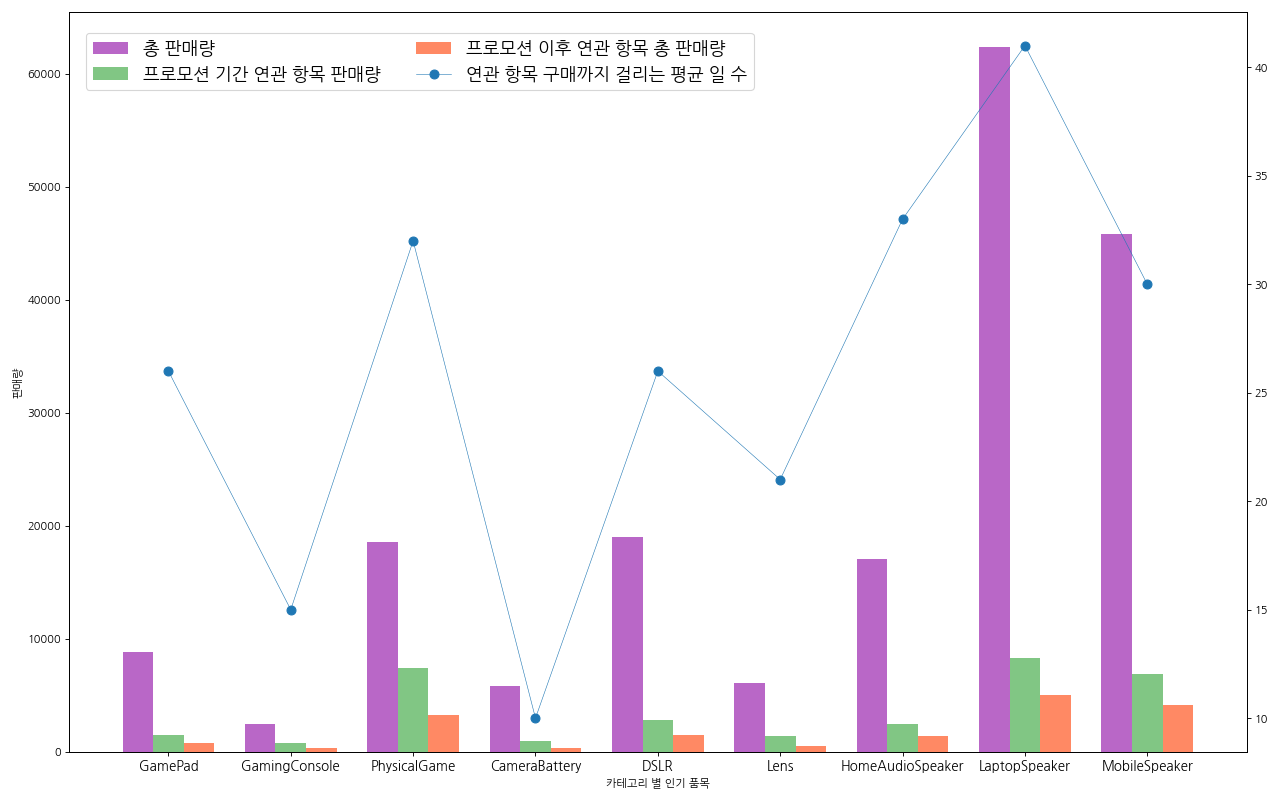

In [114]:
fig, ax1 = plt.subplots(figsize=(16, 10), dpi=80)


width = 0.25
x = np.arange(len(grouped_total['category']))


ax1.bar(x - width, grouped_total['count'], width=width, color='#9c27b0', alpha=0.7, label='총 판매량')
ax1.bar(x, grouped_total['in_promo'], width=width, color='#4caf50', alpha=0.7, label='프로모션 기간 연관 항목 판매량')
ax1.bar(x + width, grouped_total['out_promo'], width=width, color='#ff5722', alpha=0.7, label='프로모션 이후 연관 항목 총 판매량')

# for i, total in enumerate(grouped_total['count']):
#     ax1.text(x[i]-0.25, total + 1000, round(total, 1), horizontalalignment='center')

ax2 = ax1.twinx() 
ax2.plot(x, repur_total['mean'], color='#1f77b4', marker='o', linestyle='-', linewidth=0.5, markersize=8, label='연관 항목 구매까지 걸리는 평균 일 수')

# for i, mean in enumerate(repur_total['mean']):
#     ax2.text(x[i]+0.2, mean, round(mean), horizontalalignment='center')

ax1.set_xlabel('카테고리 별 인기 품목')
ax1.set_ylabel('판매량')
# ax1.set_title('인기 품목별 프로모션 기간 총 판매량 / 연관 항목 판매량', fontdict={'size':22})
ax1.set_xticks(x)
ax1.set_xticklabels(grouped_total['category'], rotation=0, ha='center', fontdict={'size':12})


handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# 모든 핸들 및 레이블을 하나로 결합
handles = handles1 + handles2
labels = labels1 + labels2

# 전체 플롯에 단일 레전드 추가
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.06, 0.97), ncol=2, prop={'size': 16})
plt.tight_layout()
plt.show()


In [115]:
nong_df = pd.concat([nong121, nong122, nong123], ignore_index=True)
nong_df

,First,Second,3%,5%,10%
0,PhysicalGame,PhysicalGame,5043972.0,8406620.0,16813241.0
1,GamePad,GamePad,1566820.0,2611367.0,5222733.0
2,GamingConsole,PhysicalGame,504695.0,841158.0,1682315.0
3,GamePad,PhysicalGame,3243296.0,5405494.0,10810988.0
4,PhysicalGame,GamePad,5962116.0,9936860.0,19873719.0
5,PhysicalGame,GamingConsole,75693496.0,126155826.0,252311653.0
6,GamingConsole,GamingConsole,4676424.0,7794041.0,15588081.0
7,PhysicalGame,GamingAccessoryKit,1777581.0,2962635.0,5925271.0
8,GamingConsole,GamePad,605581.0,1009302.0,2018605.0
9,GamePad,GamingConsole,39940653.0,66567755.0,133135510.0


In [116]:
sum3 = nong_df.groupby('First')['3%'].mean().round().reset_index()
sum5 = nong_df.groupby('First')['5%'].mean().round().reset_index()
sum10 = nong_df.groupby('First')['10%'].mean().round().reset_index()

sum_f1 = pd.merge(sum3, sum5, how='left', on='First')
sum_f = pd.merge(sum_f1, sum10, how='left', on='First')
sum_f.sort_values('3%', ascending=False)

,First,3%,5%,10%
8,PhysicalGame,22119291.0,36865485.0,73730971.0
2,GamePad,14916923.0,24861539.0,49723077.0
7,MobileSpeaker,10400322.0,17333870.0,34667741.0
1,DSLR,10298063.0,17163438.0,34326876.0
5,LaptopSpeaker,7549987.0,12583312.0,25166625.0
6,Lens,6410204.0,10683672.0,21367345.0
4,HomeAudioSpeaker,3358037.0,5596728.0,11193456.0
3,GamingConsole,1928900.0,3214834.0,6429667.0
0,CameraBattery,658786.0,1097976.0,2195952.0


In [117]:
pd.set_option('display.max_colwidth', None)

In [118]:
game_list = nong121[['First', 'Second']]
cam_list = nong122[['First', 'Second']]
ent_list = nong123[['First', 'Second']]

mer_list = pd.concat([game_list, cam_list, ent_list],ignore_index=True)
mer_list = mer_list.sort_values('First', ascending=False).reset_index(drop=True)
mer_list
df_g = mer_list.groupby('First')['Second'].apply(list).reset_index()
df_g['Second'] = df_g['Second'].apply(lambda x: ', '.join(x))
new_order = [8,2,7,1,5,6,4,3,0]
df_g_sort = df_g.loc[new_order].reset_index(drop=True)
df_g_sort

,First,Second
0,PhysicalGame,"PhysicalGame, GamingConsole, GamingAccessoryKit, GamePad"
1,GamePad,"GamePad, GamingConsole, PhysicalGame"
2,MobileSpeaker,"MobileSpeaker, LaptopSpeaker, HomeAudioSpeaker"
3,DSLR,"Filter, CameraTripod, Lens, DSLR"
4,LaptopSpeaker,"AudioMP3Player, HomeAudioSpeaker, MobileSpeaker, LaptopSpeaker"
5,Lens,"CameraTripod, Lens, Filter, DSLR, CameraBag"
6,HomeAudioSpeaker,"LaptopSpeaker, HomeAudioSpeaker, MobileSpeaker"
7,GamingConsole,"GamePad, GamingConsole, PhysicalGame"
8,CameraBattery,"CameraBattery, CameraBatteryCharger"


In [119]:
ce_sort['time'] = ce_sort['order_date'].dt.hour

In [120]:
ce_most = ce_sort[(ce_sort['product_analytic_vertical']=='DSLR')|(ce_sort['product_analytic_vertical']=='Lens')|(ce_sort['product_analytic_vertical']=='CameraBattery')
        |(ce_sort['product_analytic_vertical']=='PhysicalGame')|(ce_sort['product_analytic_vertical']=='GamingConsole')|(ce_sort['product_analytic_vertical']=='GamePad')
        |(ce_sort['product_analytic_vertical']=='LaptopSpeaker')|(ce_sort['product_analytic_vertical']=='MobileSpeaker')|(ce_sort['product_analytic_vertical']=='HomeAudioSpeaker')]

In [121]:
ce_most_n = ce_most[ce_most['promo_num'].isna()]
ce_most_m = ce_most[ce_most['promo_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11])]

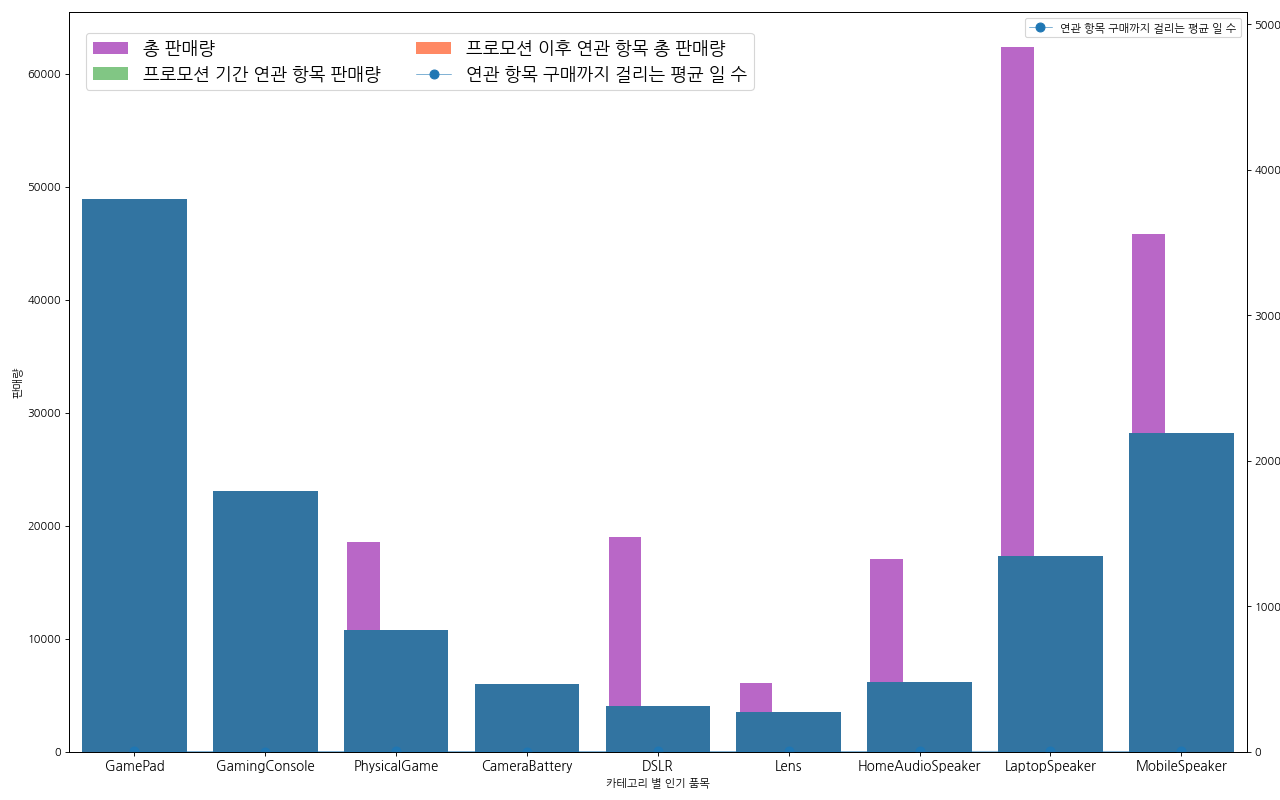

In [122]:
time_bar = ce_most_n.groupby('time')['units'].sum().reset_index()
sns.barplot(x='time', y='units', data=time_bar)
plt.show()

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


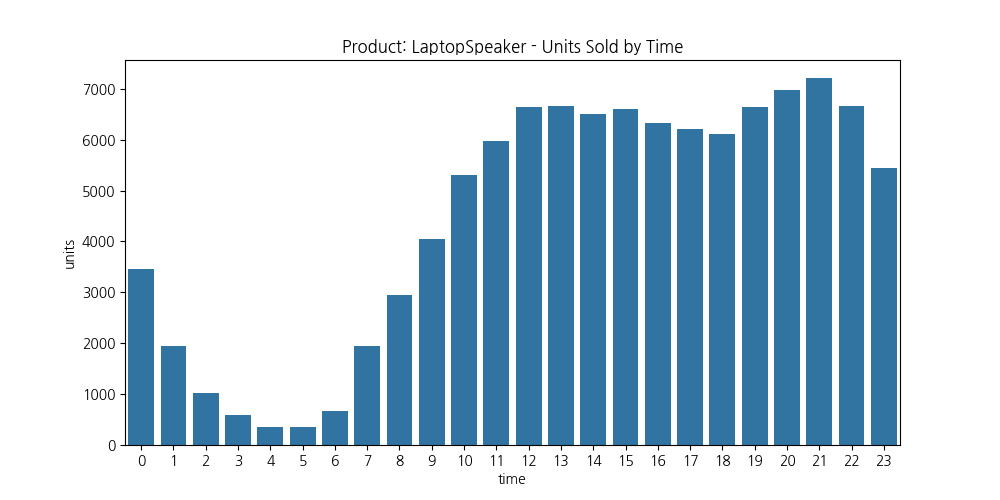

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


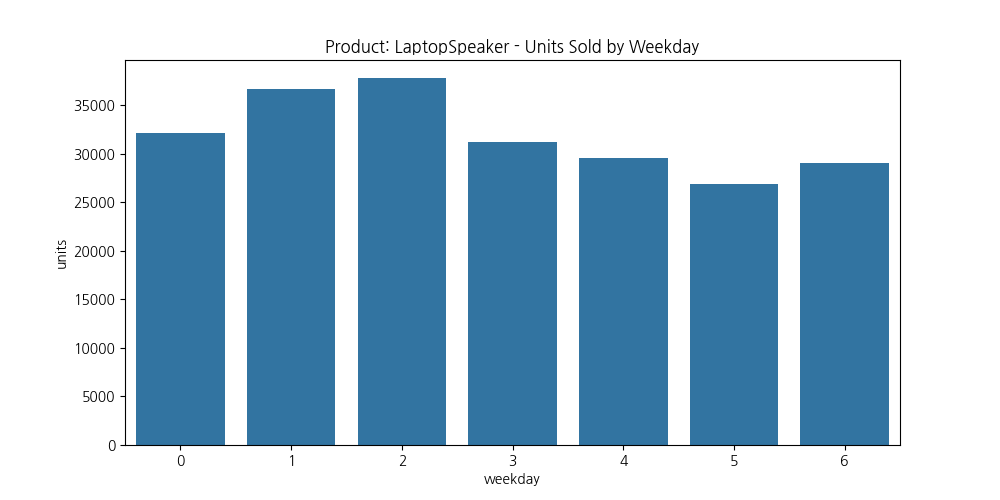

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


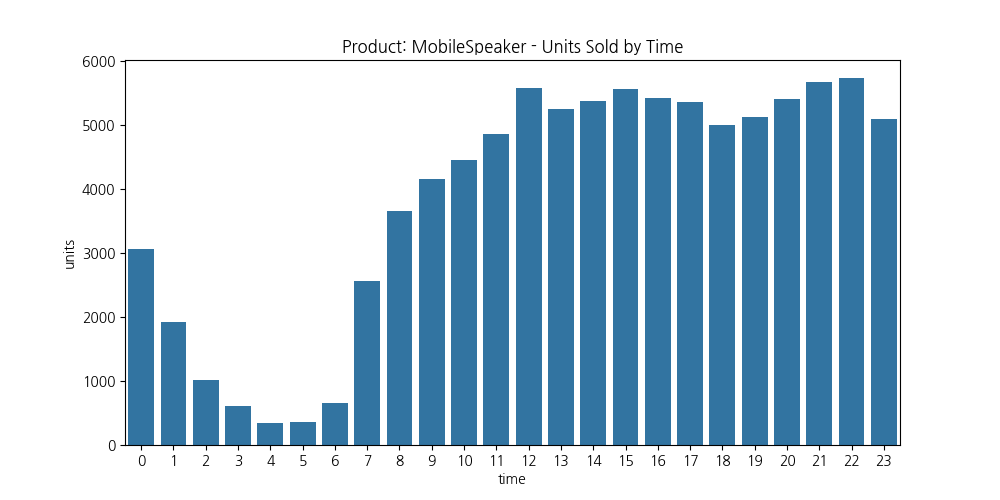

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


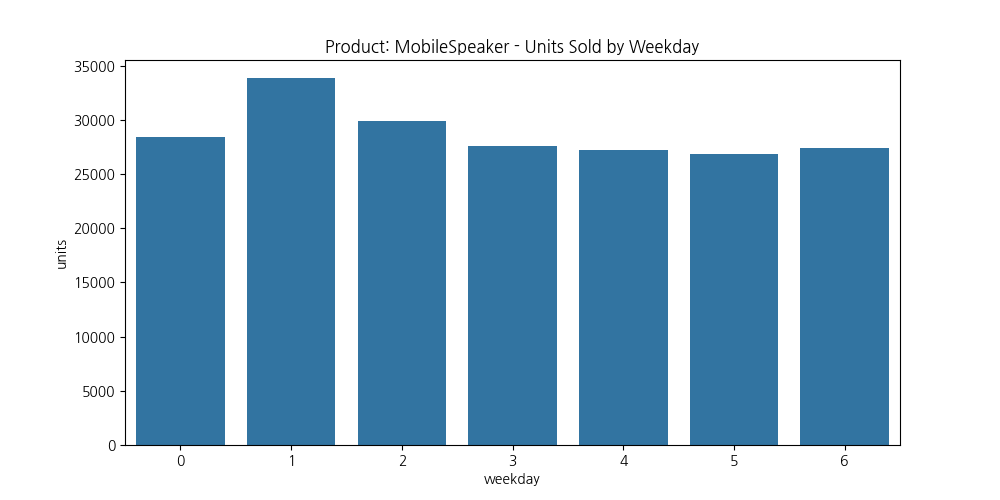

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


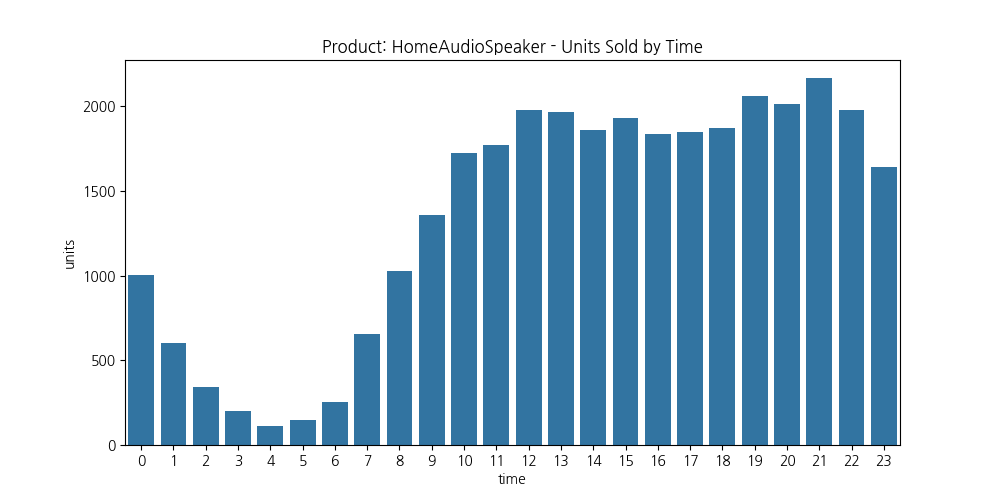

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


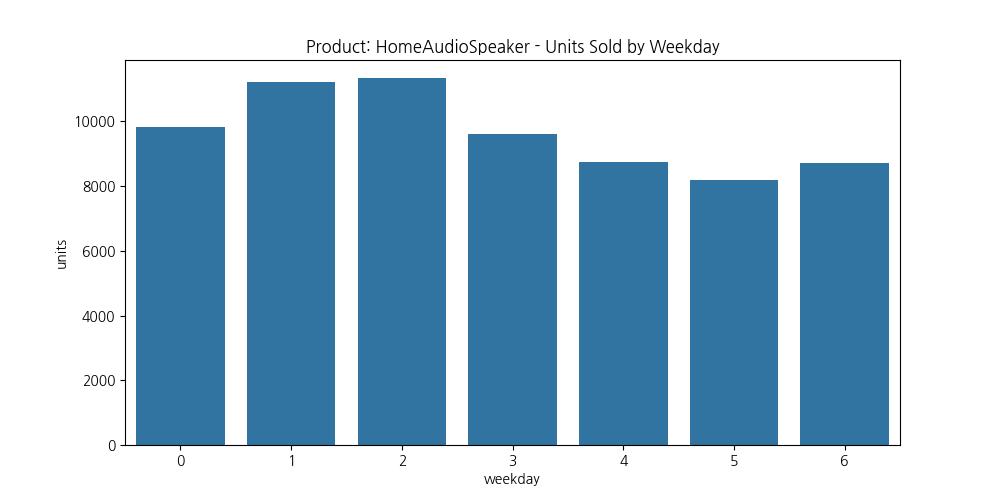

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


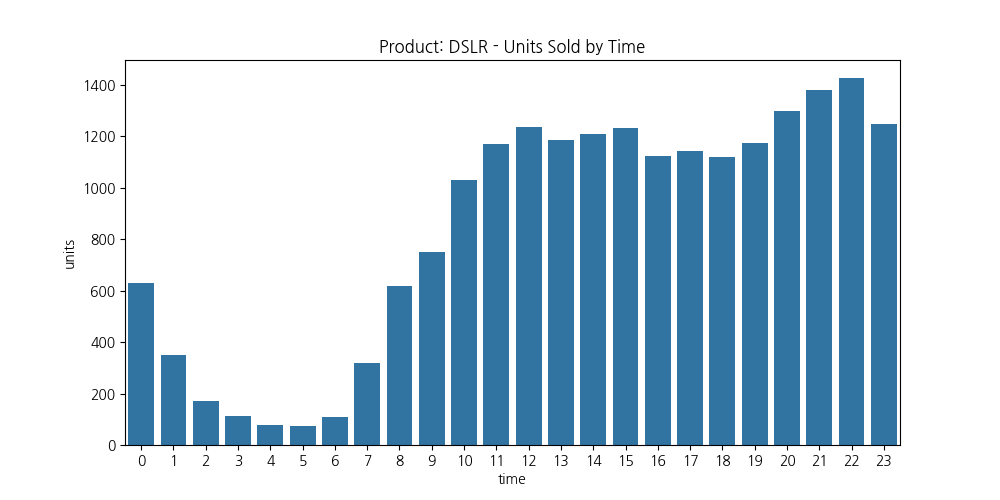

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


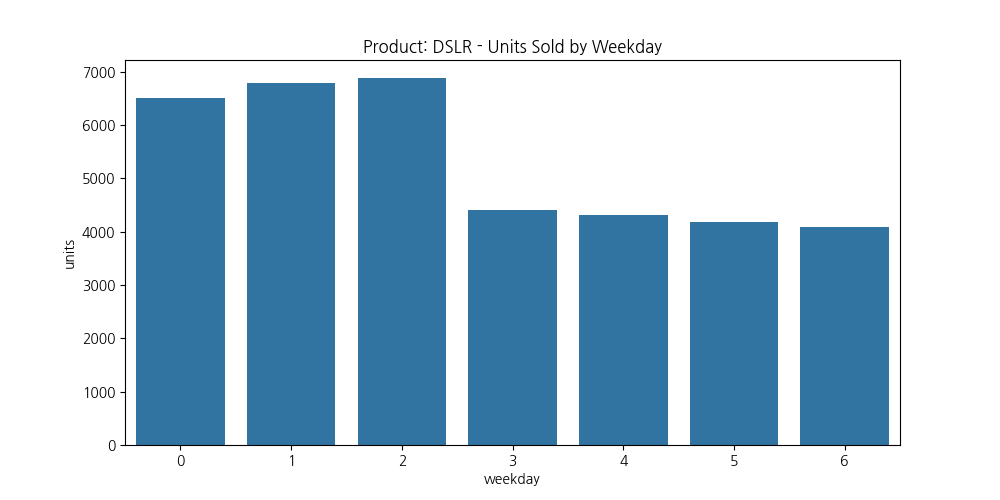

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


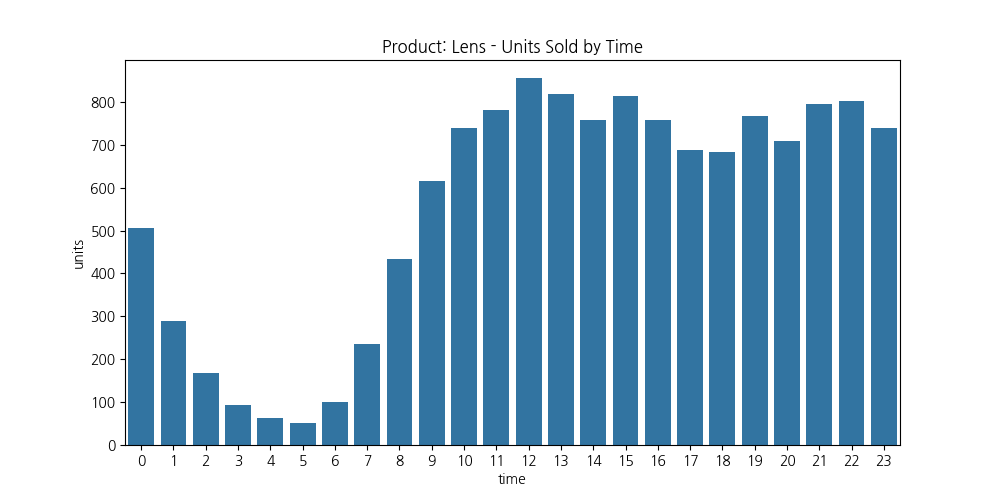

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


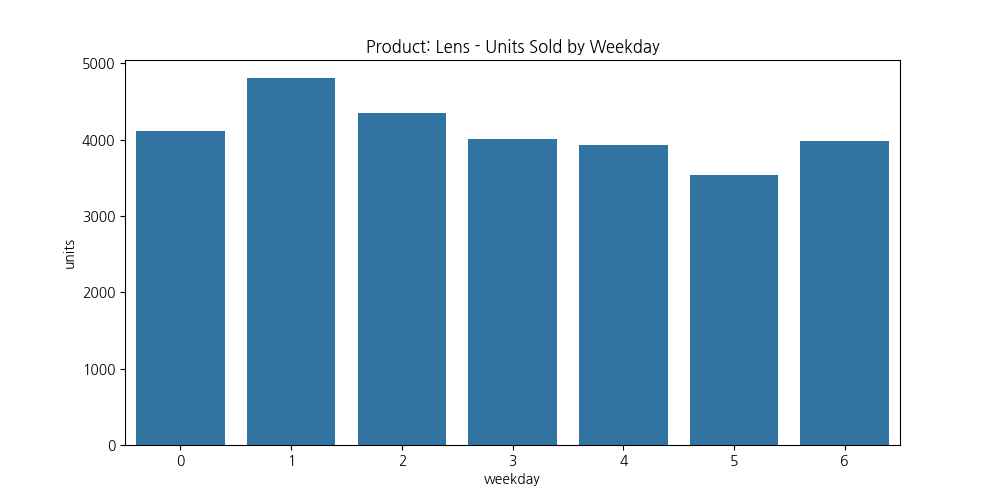

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


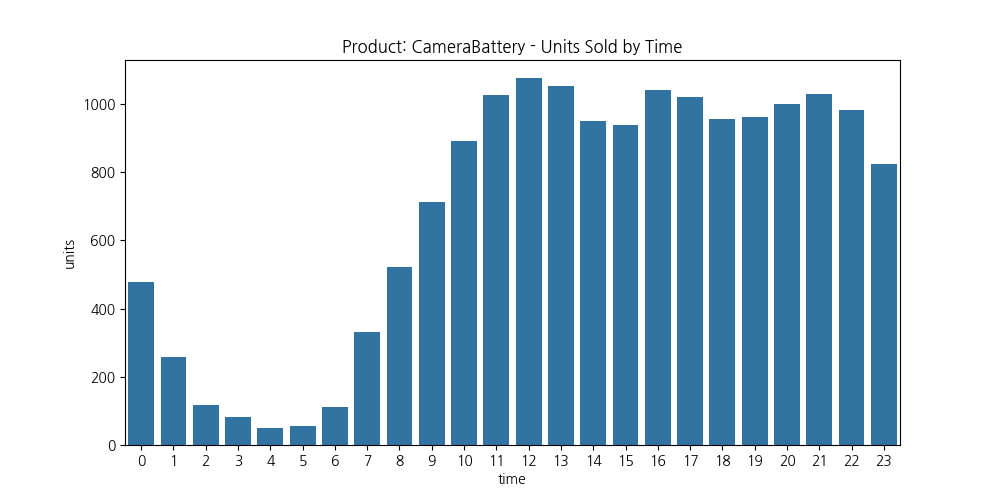

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


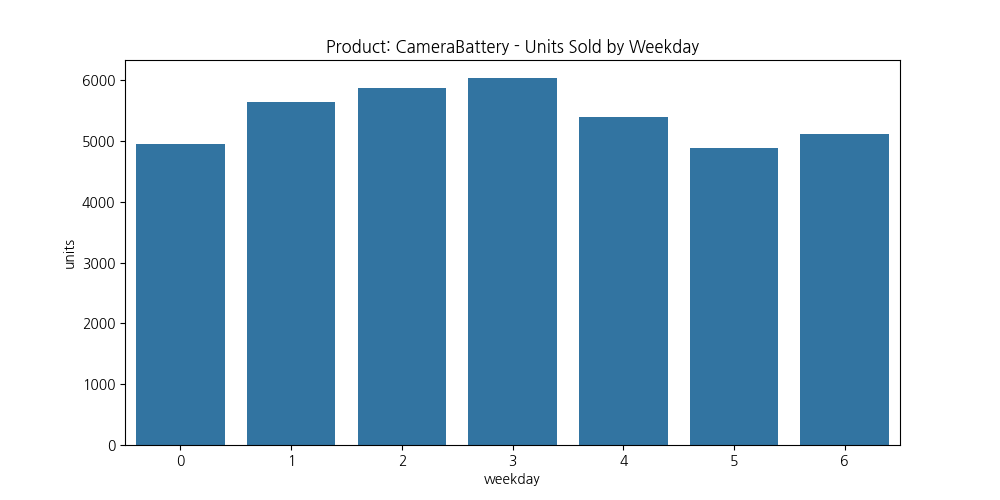

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


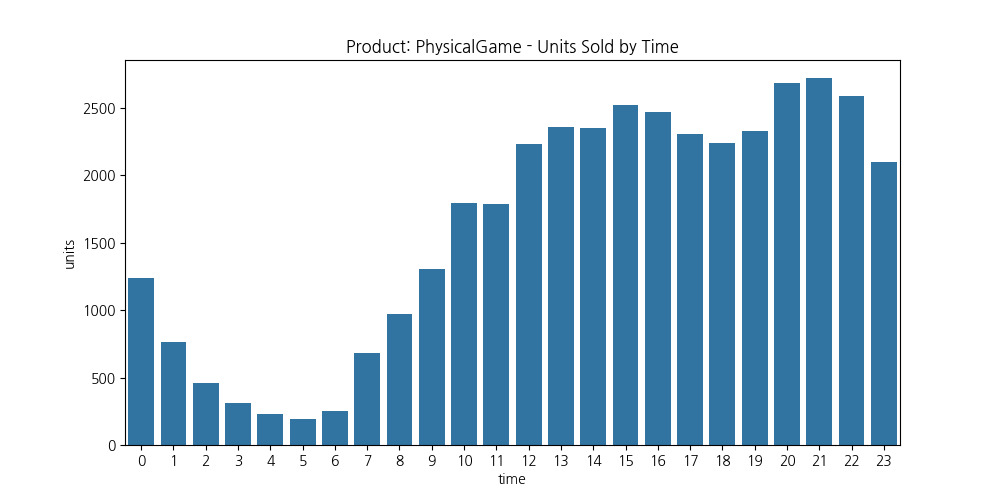

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


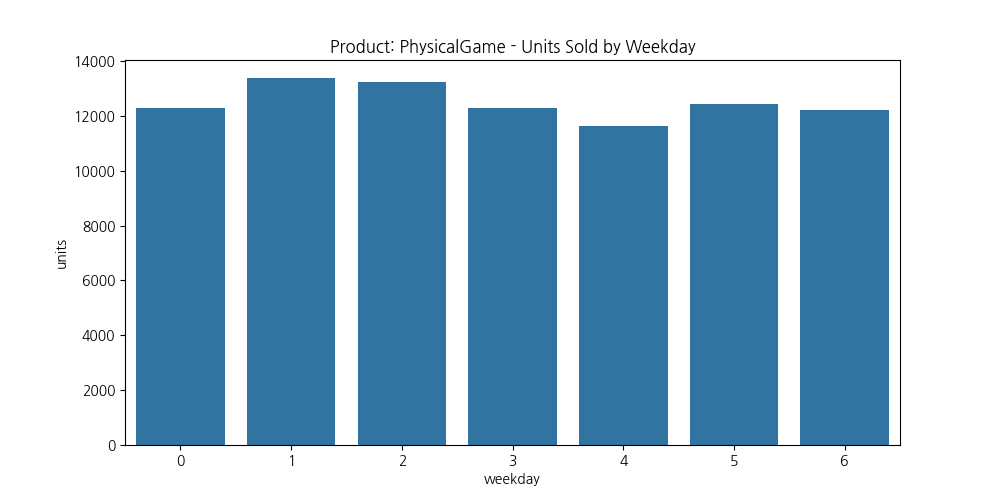

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


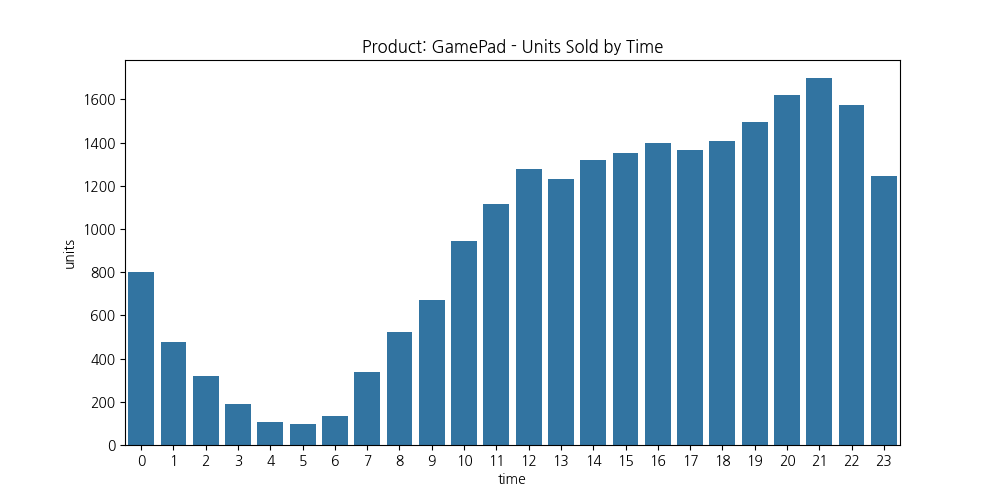

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


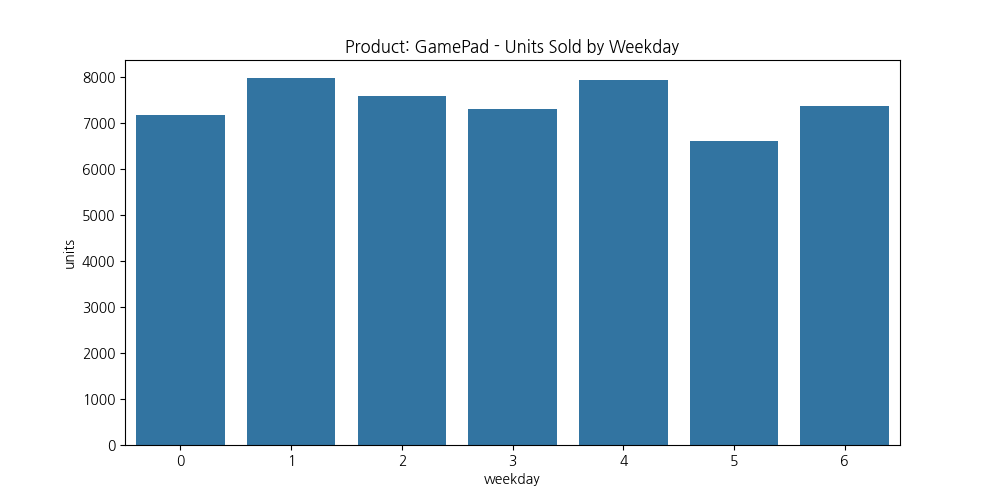

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


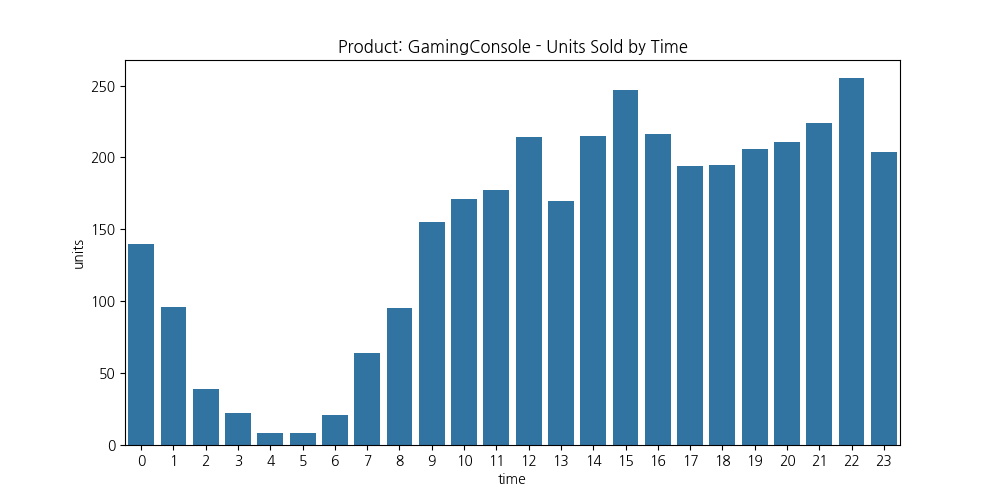

c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


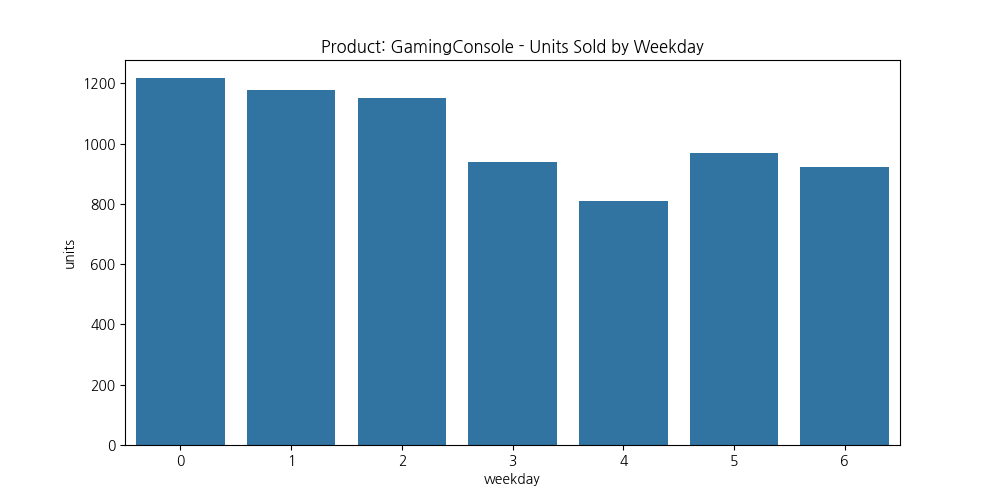

In [123]:
for val in ce_most_n['product_analytic_vertical'].unique():
    tu = ce_most_n[(ce_most_n['product_analytic_vertical']==val)&(ce_most_n['ymd']!='2016-04-27')&(ce_most_n['weekday'].isin([0,1,2]))].groupby('time')['units'].sum().reset_index()
    wu = ce_most_n[(ce_most_n['product_analytic_vertical']==val)&(ce_most_n['ymd']!='2016-04-27')].groupby('weekday')['units'].sum().reset_index()
    plt.figure(figsize=(10, 5))
    sns.barplot(x='time', y='units', data=tu)
    plt.title(f'Product: {val} - Units Sold by Time')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x='weekday', y='units', data=wu)
    plt.title(f'Product: {val} - Units Sold by Weekday')
    plt.show()

In [124]:
ce_most.groupby(['product_analytic_vertical', 'time'])['units'].sum().reset_index()

,product_analytic_vertical,time,units
0,CameraBattery,0,1970
1,CameraBattery,1,862
2,CameraBattery,2,463
3,CameraBattery,3,258
4,CameraBattery,4,157
...,...,...,...
211,PhysicalGame,19,6329
212,PhysicalGame,20,6948
213,PhysicalGame,21,6878
214,PhysicalGame,22,6683


C:\Users\user\AppData\Local\Temp\ipykernel_24836\3556652539.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))  # 'tab10' 컬러 맵 사용
c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


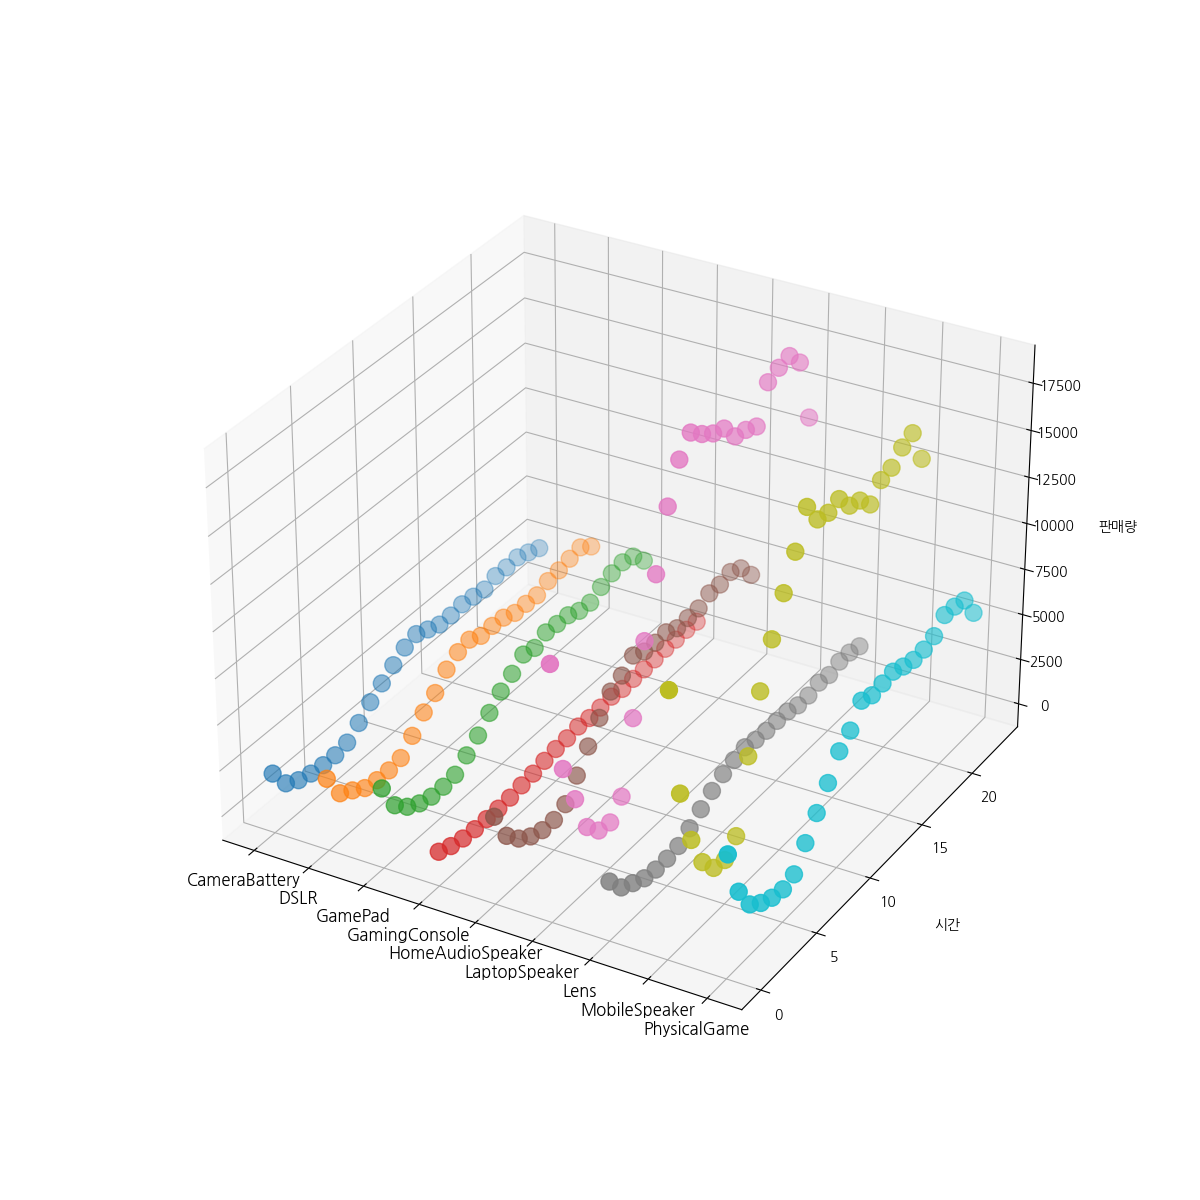

In [125]:
grouped = ce_most.groupby(['product_analytic_vertical', 'time'])['units'].sum().reset_index()

# x, y, z 데이터 추출
x = grouped['product_analytic_vertical']
y = grouped['time']
z = grouped['units']

# x, y를 숫자형으로 변환
x_labels = x.unique()
x_numeric = np.arange(len(x_labels))
x_dict = dict(zip(x_labels, x_numeric))
x_mapped = x.map(x_dict)

categories = grouped['product_analytic_vertical'].unique()
colors = plt.cm.get_cmap('tab10', len(categories))  # 'tab10' 컬러 맵 사용
color_map = {category: colors(i) for i, category in enumerate(categories)}
c_mapped = grouped['product_analytic_vertical'].map(color_map)

# 3D 플롯 생성
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter 플롯 그리기
ax.scatter(x_mapped, y, z, c=c_mapped, s=150)

# 라벨 설정
# ax.set_xlabel('카테고리', labelpad=20)
ax.set_ylabel('시간', labelpad=20)
ax.set_zlabel('판매량', labelpad=20)

# x 축에 원래의 카테고리 이름을 표시
ax.set_xticks(x_numeric)
ax.set_xticklabels(x_labels, fontsize=12)

# 그래프 보여주기
plt.show()

In [126]:
cust_cnt = ce_most.groupby('cust_id')['units'].sum().reset_index()
cust_cnt.columns = ['cust_id', 'frequency_s']
cust_mon = ce_most.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon.columns = [['cust_id', 'monetary_s']]
cust_mon = ce_most.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon.columns = ['cust_id', 'monetary_s']
cust_score = pd.merge(cust_cnt, cust_mon, how='left', on='cust_id')

In [127]:
today = datetime.now()
ce_most['rs'] = (today-ce_most['order_date']).dt.days
cust_re = ce_most.copy()
cust_re = cust_re.sort_values('order_date').drop_duplicates('cust_id', keep='last')
cust_re = cust_re[['cust_id', 'rs']]
cust_score = pd.merge(cust_score, cust_re, how='left', on='cust_id')

In [128]:

cust_score['r_score'] = 1 - MinMaxScaler().fit_transform(cust_score[['rs']])
cust_score['f_score'] = MinMaxScaler().fit_transform(cust_score[['frequency_s']])
cust_score['m_score'] = MinMaxScaler().fit_transform(cust_score[['monetary_s']])
cust_score['total_score'] = cust_score['r_score'] + cust_score['f_score']+cust_score['m_score']

In [129]:
c_m = cust_score.copy()
c_m = c_m[['cust_id', 'total_score', 'frequency_s']]
ce_most = pd.merge(ce_most, c_m,how='left', on='cust_id')

In [130]:
ce_most2 = ce_most[ce_most['frequency_s']>1]
ce_most2 = ce_most2.drop(['total_score', 'frequency_s'], axis=1)
cust_cnt2 = ce_most2.groupby('cust_id')['units'].sum().reset_index()
cust_cnt2.columns = ['cust_id', 'frequency_s']
cust_mon2 = ce_most2.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon2.columns = [['cust_id', 'monetary_s']]
cust_mon2 = ce_most2.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon2.columns = ['cust_id', 'monetary_s']
cust_score2 = pd.merge(cust_cnt2, cust_mon2, how='left', on='cust_id')
today = datetime.now()
ce_most2['rs'] = (today-ce_most2['order_date']).dt.days
cust_re2 = ce_most2.copy()
cust_re2 = cust_re2.sort_values('order_date').drop_duplicates('cust_id', keep='last')
cust_re2 = cust_re2[['cust_id', 'rs']]
cust_score2 = pd.merge(cust_score2, cust_re2, how='left', on='cust_id')
cust_score2['r_score'] = 1 - MinMaxScaler().fit_transform(cust_score2[['rs']])
cust_score2['f_score'] = MinMaxScaler().fit_transform(cust_score2[['frequency_s']])
cust_score2['m_score'] = MinMaxScaler().fit_transform(cust_score2[['monetary_s']])
cust_score2['total_score'] = cust_score2['r_score'] + cust_score2['f_score']+cust_score2['m_score']

In [131]:
c_m2 = cust_score2.copy()
c_m2 = c_m2[['cust_id', 'total_score', 'frequency_s']]
ce_most2 = pd.merge(ce_most2, c_m2,how='left', on='cust_id')

In [132]:
threshold = cust_score['total_score'].quantile(0.995)
top_0_5_cust = cust_score[cust_score['total_score'] >= threshold]['cust_id'].unique()
top = ce_most[(ce_most['cust_id'].isin(top_0_5_cust))&(ce_most['frequency_s']>1)]
under = ce_most[~ce_most['cust_id'].isin(top_0_5_cust)]

In [133]:
more_than_2 = ce_most[ce_most['frequency_s']>1]
under_2 = ce_most[ce_most['frequency_s']<=1]

In [134]:
pgg = ce_sort[ce_sort['product_analytic_vertical']=='PhysicalGame']['gmv'].reset_index().sort_values('gmv')
pgg[pgg['gmv']==0]

,index,gmv
49633,1052266,0.0
36511,480601,0.0
18187,1052233,0.0
14446,1052237,0.0
49636,1052258,0.0
...,...,...
62300,913694,0.0
62301,918545,0.0
62302,913619,0.0
31042,480609,0.0


In [135]:
threshold = cust_score2['total_score'].quantile(0.995)
top_0_5_cust2 = cust_score2[cust_score2['total_score'] >= threshold]['cust_id'].unique()
top2 = ce_most2[(ce_most2['cust_id'].isin(top_0_5_cust2))&(ce_most['frequency_s']>1)]
under2 = ce_most2[~ce_most2['cust_id'].isin(top_0_5_cust2)]

In [136]:
ce_sort3 = ce_sort.copy()
# ce_sort3 = ce_sort3.drop(['total_score', 'frequency_s'], axis=1)
cust_cnt3 = ce_sort3.groupby('cust_id')['units'].sum().reset_index()
cust_cnt3.columns = ['cust_id', 'frequency_s']
cust_mon3 = ce_sort3.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon3.columns = [['cust_id', 'monetary_s']]
cust_mon3 = ce_sort3.groupby('cust_id')['gmv'].sum().reset_index()
cust_mon3.columns = ['cust_id', 'monetary_s']
cust_score3 = pd.merge(cust_cnt3, cust_mon3, how='left', on='cust_id')
today = datetime.now()
ce_sort3['rs'] = (today-ce_sort3['order_date']).dt.days
cust_re3 = ce_sort3.copy()
cust_re3 = cust_re3.sort_values('order_date').drop_duplicates('cust_id', keep='last')
cust_re3 = cust_re3[['cust_id', 'rs']]
cust_score3 = pd.merge(cust_score3, cust_re3, how='left', on='cust_id')
cust_score3['r_score'] = 1 - MinMaxScaler().fit_transform(cust_score3[['rs']])
cust_score3['f_score'] = MinMaxScaler().fit_transform(cust_score3[['frequency_s']])
cust_score3['m_score'] = MinMaxScaler().fit_transform(cust_score3[['monetary_s']])
cust_score3['total_score'] = cust_score3['r_score'] + cust_score3['f_score']+cust_score3['m_score']

In [137]:
c_m3 = cust_score3.copy()
c_m3 = c_m3[['cust_id', 'total_score', 'frequency_s']]
ce_sort3 = pd.merge(ce_sort3, c_m3,how='left', on='cust_id')
ce_sort3.head()

,fsn_id,order_date,Year,Month,gmv,units,s1_fact.order_payment_type,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,ymd,weekday,promo_num,tomorrow,pre_prd,pre_fsn,pre_ymd,re_pur,next_pur,C,time,rs,total_score,frequency_s
0,VGLEJ4UAJAHE7FW4,2016-05-30 13:47:39,2016,5,1599.0,1,COD,-1000001381692640000,-3762359311595820032,CE,EntertainmentSmall,TVVideoSmall,VideoGlasses,2016-05-30,0,NaN,3237.0,None,None,NaT,NaN,-227.0,0.0,13,3010,0.871388,1
1,ACCE9C3WYBMPJ98R,2015-10-16 03:02:36,2015,10,799.0,1,COD,-1000001979650759936,5186887196113999872,CE,EntertainmentSmall,Speaker,MobileSpeaker,2015-10-16,4,3.0,3237.0,VideoGlasses,VGLEJ4UAJAHE7FW4,2016-05-30,-227.0,0.0,0.0,3,3237,0.352292,2
2,ACCE9R3UDGBBE4ZY,2015-10-16 03:53:44,2015,10,799.0,1,COD,-1000001979650759936,5186887196113999872,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2015-10-16,4,3.0,3001.0,MobileSpeaker,ACCE9C3WYBMPJ98R,2015-10-16,0.0,236.0,NaN,3,3237,0.352292,2
3,ACCE4DSWGX4AFJEG,2016-06-07 19:56:04,2016,6,549.0,1,COD,-1000003817188710016,3668379099757700096,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2016-06-07,1,NaN,2988.0,LaptopSpeaker,ACCE9R3UDGBBE4ZY,2015-10-16,236.0,13.0,0.0,19,3001,0.891701,1
4,CBGEYECTT9G44UGM,2016-06-21 11:37:46,2016,6,2999.0,1,Prepaid,-1000013054844720000,-1401890979172369920,CE,CameraAccessory,CameraAccessory,CameraBatteryGrip,2016-06-21,1,NaN,3211.0,LaptopSpeaker,ACCE4DSWGX4AFJEG,2016-06-07,13.0,-223.0,0.0,11,2988,0.922824,1


In [138]:
ce_most2['score'] = MinMaxScaler().fit_transform(ce_most2[['total_score']])*100
ce_most2["grade"] = np.where(ce_most2['score'] > 37.301790, "A",
                    np.where(ce_most2['score'] > 25.045607, "B",
                    np.where(ce_most2['score'] > 11.099852, "C", "D")))
ce_most2.head()

,fsn_id,order_date,Year,Month,gmv,units,s1_fact.order_payment_type,cust_id,pincode,product_analytic_super_category,product_analytic_category,product_analytic_sub_category,product_analytic_vertical,ymd,weekday,promo_num,tomorrow,pre_prd,pre_fsn,pre_ymd,re_pur,next_pur,C,time,rs,total_score,frequency_s,score,grade
0,ACCE9C3WYBMPJ98R,2015-10-16 03:02:36,2015,10,799.0,1,COD,-1000001979650759936,5186887196113999872,CE,EntertainmentSmall,Speaker,MobileSpeaker,2015-10-16,4,3.0,3237.0,VideoGlasses,VGLEJ4UAJAHE7FW4,2016-05-30,-227.0,0.0,0.0,3,3237,0.273559,2,13.140387,C
1,ACCE9R3UDGBBE4ZY,2015-10-16 03:53:44,2015,10,799.0,1,COD,-1000001979650759936,5186887196113999872,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2015-10-16,4,3.0,3001.0,MobileSpeaker,ACCE9C3WYBMPJ98R,2015-10-16,0.0,236.0,NaN,3,3237,0.273559,2,13.140387,C
2,ACCE6GEHCGDZQDZP,2015-09-11 21:17:27,2015,9,1499.0,1,COD,-1000228635118979968,-1927138204374640128,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2015-09-11,4,NaN,3271.0,GamingHeadset,ACCE9HUUYYSGTUXZ,2016-05-18,-250.0,0.0,0.0,21,3271,0.185975,2,8.905940,D
3,ACCE6GEHCGDZQDZP,2015-09-11 21:17:27,2015,9,1499.0,1,COD,-1000228635118979968,-1927138204374640128,CE,EntertainmentSmall,Speaker,LaptopSpeaker,2015-09-11,4,NaN,3236.0,LaptopSpeaker,ACCE6GEHCGDZQDZP,2015-09-11,0.0,35.0,NaN,21,3271,0.185975,2,8.905940,D
4,AVMDJVX6GVBRRMZU,2015-09-11 20:03:15,2015,9,1585.0,1,Prepaid,-1000427740920150016,6896637658053289984,CE,GameCDDVD,Game,PhysicalGame,2015-09-11,4,NaN,3271.0,GamingAdapter,ACCDYQ9EZQEN2USE,2015-10-30,-48.0,0.0,0.0,20,3271,0.198446,4,9.508858,D


In [139]:
vertical_list_top = ce_most2[ce_most2['grade']=='A'].sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

min_support = 1000

frequent_sequences = apriori_all(vertical_list_top, min_support)

seq_data = {'sequence': [], 'count': []}

for sequence, count in frequent_sequences:
    seq_data['sequence'].append(sequence)
    seq_data['count'].append(count)

seq = pd.DataFrame(seq_data)


print(seq)

                                                                  sequence  \
0                                                         (MobileSpeaker,)   
1                                                         (GamingConsole,)   
2                                                                  (Lens,)   
3                                                      (HomeAudioSpeaker,)   
4                                                                  (DSLR,)   
5                                                         (CameraBattery,)   
6                                                         (LaptopSpeaker,)   
7                                                               (GamePad,)   
8                                                          (PhysicalGame,)   
9                                     (HomeAudioSpeaker, HomeAudioSpeaker)   
10                                                            (DSLR, Lens)   
11                                           (GamingConsole, Phy

In [140]:
seq = seq.copy()
seq['sequence'] = seq['sequence'].astype(str).str.strip('()')

max_items = seq['sequence'].astype(str).str.split(', ', expand=True).shape[1]

seq_expanded = seq['sequence'].astype(str).str.split(', ', expand=True, n=max_items-1)

seq_expanded[0] = seq_expanded[0].astype(str).str.strip(',')
seq_expanded[0] = seq_expanded[0].astype(str).str.strip("''")
seq_expanded[1] = seq_expanded[1].astype(str).str.strip("''")
seq_expanded[2] = seq_expanded[2].astype(str).str.strip("''")
seq_expanded[3] = seq_expanded[2].astype(str).str.strip("''")
seq_expanded[4] = seq_expanded[2].astype(str).str.strip("''")

seq_expanded

,0,1,2,3,4
0,MobileSpeaker,None,None,None,None
1,GamingConsole,None,None,None,None
2,Lens,None,None,None,None
3,HomeAudioSpeaker,None,None,None,None
4,DSLR,None,None,None,None
5,CameraBattery,None,None,None,None
6,LaptopSpeaker,None,None,None,None
7,GamePad,None,None,None,None
8,PhysicalGame,None,None,None,None
9,HomeAudioSpeaker,HomeAudioSpeaker,None,None,None


In [141]:
vertical_list_top = ce_most2[ce_most2['grade']=='D'].sort_values(['cust_id', 'order_date']).groupby(['cust_id'])['product_analytic_vertical'].apply(list).tolist()

min_support = 900

frequent_sequences = apriori_all(vertical_list_top, min_support)

seq_data = {'sequence': [], 'count': []}

for sequence, count in frequent_sequences:
    seq_data['sequence'].append(sequence)
    seq_data['count'].append(count)

seq = pd.DataFrame(seq_data)


print(seq)

                                sequence  count
0                       (MobileSpeaker,)  10097
1                                (Lens,)   1768
2                       (CameraBattery,)   2828
3                    (HomeAudioSpeaker,)   4575
4                       (LaptopSpeaker,)  17867
5                             (GamePad,)   4231
6                        (PhysicalGame,)   3446
7   (HomeAudioSpeaker, HomeAudioSpeaker)   4374
8                     (GamePad, GamePad)   3883
9         (MobileSpeaker, MobileSpeaker)   9792
10          (PhysicalGame, PhysicalGame)   3334
11                          (Lens, Lens)   1669
12        (CameraBattery, CameraBattery)   2603
13        (LaptopSpeaker, LaptopSpeaker)  17382


In [142]:
seq = seq.copy()
seq['sequence'] = seq['sequence'].astype(str).str.strip('()')

max_items = seq['sequence'].astype(str).str.split(', ', expand=True).shape[1]

seq_expanded = seq['sequence'].astype(str).str.split(', ', expand=True, n=max_items-1)

seq_expanded[0] = seq_expanded[0].astype(str).str.strip(',')
seq_expanded[0] = seq_expanded[0].astype(str).str.strip("''")
seq_expanded[1] = seq_expanded[1].astype(str).str.strip("''")
#seq_expanded[2] = seq_expanded[2].astype(str).str.strip("''")
seq_expanded

,0,1
0,MobileSpeaker,None
1,Lens,None
2,CameraBattery,None
3,HomeAudioSpeaker,None
4,LaptopSpeaker,None
5,GamePad,None
6,PhysicalGame,None
7,HomeAudioSpeaker,HomeAudioSpeaker
8,GamePad,GamePad
9,MobileSpeaker,MobileSpeaker


In [143]:
ga = ce_most2[ce_most2['grade']=='A']['product_analytic_vertical'].value_counts().head(6).reset_index()
ga.columns = ['product', 'A']
gb = ce_most2[ce_most2['grade']=='B']['product_analytic_vertical'].value_counts().head(6).reset_index()
gb.columns = ['product', 'B']
gc = ce_most2[ce_most2['grade']=='C']['product_analytic_vertical'].value_counts().head(6).reset_index()
gc.columns = ['product', 'C']
gd = ce_most2[ce_most2['grade']=='D']['product_analytic_vertical'].value_counts().head(6).reset_index()
gd.columns = ['product', 'D']
ga, gb, gc, gd
gr1 = pd.merge(ga,gb,how='outer', on='product')
gr2 = pd.merge(gr1,gc,how='outer', on='product')
df = pd.merge(gr2,gd,how='outer', on='product')
df = df.fillna(0)
df

,product,A,B,C,D
0,PhysicalGame,29068.0,17372.0,11481.0,7398.0
1,MobileSpeaker,26300.0,27011.0,21994.0,20875.0
2,LaptopSpeaker,14526.0,20943.0,36554.0,36911.0
3,GamePad,7546.0,6831.0,6803.0,8585.0
4,DSLR,5826.0,6237.0,5077.0,0.0
5,HomeAudioSpeaker,5386.0,8273.0,9412.0,9317.0
6,CameraBattery,0.0,0.0,0.0,5819.0


c:\Users\user\anaconda3\envs\ds_study\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


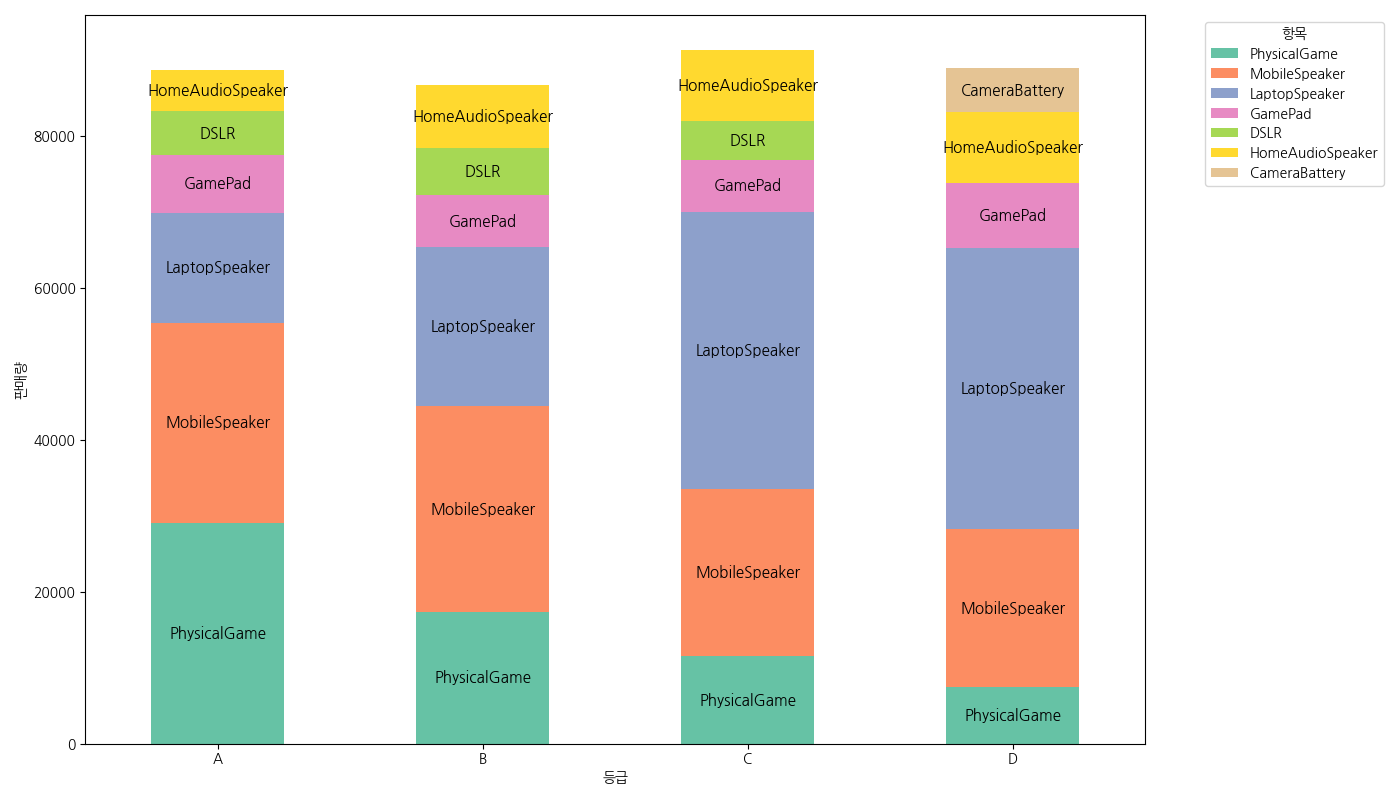

In [144]:
plt.figure(figsize=(14, 8))
colors = plt.cm.Set2.colors

# 누적 막대 차트 그리기
ax = df.set_index('product').T.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors)

plt.title('')
plt.xlabel('등급')
plt.ylabel('판매량')
plt.xticks(rotation=0)
products = df['product'].values
for container, product_name in zip(ax.containers, products):
    for rect in container:
        height = rect.get_height()
        if height > 0:  # 높이가 0보다 큰 경우에만 표시
            ax.text(
                rect.get_x() + rect.get_width() / 2,  # x 위치
                rect.get_y() + height / 2,  # y 위치
                product_name,  # 각 영역에 해당하는 product 이름 표시
                ha='center', va='center', color='black', fontsize=11  # 텍스트 가운데 정렬
            )
ax.legend(title='항목', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [145]:
a_c = ce_most2[ce_most2['grade']=='A']['cust_id'].nunique()

In [146]:
a_f = ce_most2[ce_most2['grade']=='A'].groupby('cust_id')['frequency_s'].mean().sum()

In [147]:
t_c = ce_sort['cust_id'].nunique()

In [148]:
t_f = ce_sort['units'].sum()

In [149]:
print(f'''
      A등급: {a_f*100/a_c}
      전체: {t_f*100/t_c}''')


      A등급: 306.2530801565444
      전체: 139.89013303760171


In [150]:
pid = ce_most2[(ce_most2['grade']=='A')&(ce_most2['product_analytic_vertical']=='PhysicalGame')]['cust_id'].unique()
a_c = ce_most2[(ce_most2['grade']=='A')&(ce_most2['cust_id'].isin(pid))]['cust_id'].nunique()
a_f = ce_most2[(ce_most2['grade']=='A')&(ce_most2['cust_id'].isin(pid))].groupby('cust_id')['frequency_s'].mean().sum()
t_c = ce_sort['cust_id'].nunique()
t_f = ce_sort['units'].sum()
print(f'''
      A등급: {round(a_f/a_c,2)}
      A 총 고객: {a_c}
      전체: {round(t_f/t_c,2)}''')


      A등급: 4.11
      A 총 고객: 9572
      전체: 1.4


In [151]:
pid = ce_most2[(ce_most2['grade']=='B')&(ce_most2['product_analytic_vertical']=='PhysicalGame')]['cust_id'].unique()
b_c = ce_most2[(ce_most2['grade']=='B')&(ce_most2['cust_id'].isin(pid))]['cust_id'].nunique()
b_f = ce_most2[(ce_most2['grade']=='B')&(ce_most2['cust_id'].isin(pid))].groupby('cust_id')['frequency_s'].mean().sum()
pidc = ce_most2[(ce_most2['grade']=='C')&(ce_most2['product_analytic_vertical']=='PhysicalGame')]['cust_id'].unique()
c_c = ce_most2[(ce_most2['grade']=='C')&(ce_most2['cust_id'].isin(pidc))]['cust_id'].nunique()
c_f = ce_most2[(ce_most2['grade']=='C')&(ce_most2['cust_id'].isin(pidc))].groupby('cust_id')['frequency_s'].mean().sum()
pidd = ce_most2[(ce_most2['grade']=='D')&(ce_most2['product_analytic_vertical']=='PhysicalGame')]['cust_id'].unique()
d_c = ce_most2[(ce_most2['grade']=='D')&(ce_most2['cust_id'].isin(pidd))]['cust_id'].nunique()
d_f = ce_most2[(ce_most2['grade']=='D')&(ce_most2['cust_id'].isin(pidd))].groupby('cust_id')['frequency_s'].mean().sum()
print(f'''
      B등급: {round(b_f/b_c,2)}
      B 총 고객: {b_c}
      C등급: {round(c_f/c_c,2)}
      C 총 고객: {c_c}
      D등급: {round(d_f/d_c,2)}
      D 총 고객: {d_c}''')


      B등급: 3.04
      B 총 고객: 7590
      C등급: 2.8
      C 총 고객: 5284
      D등급: 2.28
      D 총 고객: 3446


In [152]:
ce_most2[ce_most2['product_analytic_vertical']=='PhysicalGame']['gmv'].mean()

2064.0167328144457

In [153]:
print(f'''
      B등급 기대이익 {7585*1.1*2064}
      C등급 기대이익 {5206*1.3*2064}
      D등급 기대이익 {3567*1.8*2064}
      ''')


      B등급 기대이익 17220984.0
      C등급 기대이익 13968739.200000001
      D등급 기대이익 13252118.4
      


In [154]:
print(f'''
      B등급 3% 기대이익 {(7585+7585*0.03)*1.1*2064}
      C등급 3% 기대이익 {(5206+5206*0.03)*1.3*2064}
      D등급 3% 기대이익 {(3567+3567*0.03)*1.8*2064}
      B등급 5% 기대이익 {(7585+7585*0.05)*1.1*2064}
      C등급 5% 기대이익 {(5206+5206*0.05)*1.3*2064}
      D등급 5% 기대이익 {(3567+3567*0.05)*1.8*2064}
      B등급 10% 기대이익 {(7585+7585*0.1)*1.1*2064}
      C등급 10% 기대이익 {(5206+5206*0.1)*1.3*2064}
      D등급 10% 기대이익 {(3567+3567*0.1)*1.8*2064}
      ''')


      B등급 3% 기대이익 17737613.52
      C등급 3% 기대이익 14387801.376000002
      D등급 3% 기대이익 13649681.952000001
      B등급 5% 기대이익 18082033.200000003
      C등급 5% 기대이익 14667176.16
      D등급 5% 기대이익 13914724.32
      B등급 10% 기대이익 18943082.400000002
      C등급 10% 기대이익 15365613.120000001
      D등급 10% 기대이익 14577330.24
      


In [155]:
dfdfdf = {'Grade': ['B', 'C', 'D'],
          '3%': [17737613, 14387801, 13649681],
          '5%': [18082033, 14667176, 13914724],
          '10%': [18943082, 15365613, 14577330],
          }
dfdfdf = pd.DataFrame(dfdfdf)
dfdfdf

,Grade,3%,5%,10%
0,B,17737613,18082033,18943082
1,C,14387801,14667176,15365613
2,D,13649681,13914724,14577330


In [156]:
ce_most[ce_most['product_analytic_vertical']==val].groupby('time')['units'].sum().reset_index()

,time,units
0,0,579
1,1,299
2,2,127
3,3,55
4,4,29
5,5,24
6,6,57
7,7,163
8,8,244
9,9,388
